# Read in weather data & convert in SI units

Read in the different types of weather data from different providers (NWCC, NWAC, USGS). Bring all data products to the same format. To goal is to convert the units to SI units and use the same timestamps for all parameters.

Also part of this script here is to plot the data products to compare them with each other (are they redundant or maybe not usefull for my use). Finally, save the manipulated weather data products all in the same way and useing the final SI units so that in the real script (when seismic data comes in) no weather data manipulation has to be done, except from resampling and rolling.

<font color='red'>Make sure to start from scratch. I had once the problem that the DataFrame got extended instead of overwritten every time I run the script and did not start at the beginning. Check DataFrame column names before saving.</font>

In [1]:
import numpy as np
import pandas as pd
import glob
import datetime
# from obspy import UTCDateTime
import matplotlib.pyplot as plt

In [2]:
path = './data/weather/' # path to weather data folder

In [52]:
# function to convert units to SI units
def feet2meters(column_in_feet):
    """
    Convert a Pandas DataFrame column from feet to meters.
    
    Parameters:
        column_in_feet (pandas.Series): The Pandas DataFrame column in feet.

    Returns:
        pandas.Series: The converted column in meters.
    """
    # Conversion factor: 1 foot = 0.3048 meters
    conversion_factor = 0.3048
    
    # Use the conversion factor to convert the column
    column_in_meters = column_in_feet * conversion_factor
    
    return column_in_meters

def inch2meters(column_in_inch):
    """
    Convert a Pandas DataFrame column from inches to meters.
    
    Parameters:
        column_in_inches (pandas.Series): The Pandas DataFrame column in inches.

    Returns:
        pandas.Series: The converted column in meters.
    """
    # Conversion factor: 1 inch = 0.0254 meters
    conversion_factor = 0.0254
    
    # Use the conversion factor to convert the column
    column_in_meters = column_in_inch * conversion_factor
    
    return column_in_meters

def mph2ms(column_in_mph):
    """
    Convert miles per hour to meters per second.
    
    Parameters:
        column_in_mph (pandas.Series): The Pandas DataFrame column in miles per hour.

    Returns:
        pandas.Series: The converted column in meters per second.
    """
    # Conversion factor: 1 mile per hour = 0.44704 meters per second
    conversion_factor = 0.44704
    
    # Use the conversion factor to convert the column
    column_in_ms = column_in_mph * conversion_factor
    
    return column_in_ms

def cfs2cms(column_in_cfs):
    """
    Convert cubic feet per second (cfs) to cubic meters per second (cms).
    
    Parameters:
        column_in_cfs (pandas.Series): The Pandas DataFrame column in cubic feet per second (cfs).

    Returns:
        pandas.Series: The converted column in cubic meters per second (cms).
    """
    # Conversion factor: 1 cubic foot per second = 0.0283168 cubic meters per second
    conversion_factor = 0.0283168
    
    # Use the conversion factor to convert the column
    column_in_cms = column_in_cfs * conversion_factor
    
    return column_in_cms


def fahrenheit2celsius(column_in_fahrenheit):
    """
    Convert degrees Fahrenheit to degrees Celsius.
    
    Parameters:
        degrees_fahrenheit (float or pandas.Series): Temperature in degrees Fahrenheit.

    Returns:
        float or pandas.Series: Temperature in degrees Celsius.
    """
    # Conversion formula: Celsius = (Fahrenheit - 32) * 5/9
    degrees_celsius = (column_in_fahrenheit - 32) * 5/9
    
    return degrees_celsius


## NWAC data
It seems like they started collecting the data in 2016. The data are collected and stored in PST timezone which is 8 hours behind UTC.

### Read data, built df for each station and convert time

In [4]:
# create an array with all NWAC stations
NWAC_sta_arr = np.unique([f.split('/')[-1] for f in sorted(glob.glob(path+'NWAC/*'))])
NWAC_sta_arr

array(['CampMuir', 'Paradise', 'Sunrise'], dtype='<U8')

In [5]:
# Initialize an empty dictionary
result_dict = {}

# Loops over all stations in NWAC_sta_arr
for NWAC_sta in NWAC_sta_arr:
    li = []
    # Loops over all files of one station folder
    for NWAC_file in np.unique(sorted(glob.glob(path+f'NWAC/{NWAC_sta}/*'))):
        # Extract sub-station name
        sub_sta = NWAC_file.split('/')[-1].split('_')[0]
        # Read CSV file into DataFrame
        df_year = pd.read_csv(NWAC_file)
        # Remove trailing spaces from column names
        cols = df_year.columns.str.strip()
        # Replace consecutive spaces with a single space
        cols = cols.str.replace(r'\s+', ' ', regex=True)
        print(cols)
        # Replace the column names in df_year with the cleaned column names
        df_year.columns = cols
        # Get a list of column names containing 'Battery Voltage (v)', '24 Hour Snow (")'
        columns_to_drop = cols[cols.str.contains('Battery Voltage \(v\)|24 Hour Snow \("\)')]
        print(columns_to_drop)
        # Drop columns containing 'Battery Voltage (v)', '24 Hour Snow (m)' from cols
        cols = cols.drop(columns_to_drop)
        # Drop columns containing 'Battery Voltage (v)', '24 Hour Snow (m)'
        df_year.drop(columns_to_drop, axis=1, inplace=True)
        # Format column names, adding sub-station name if not 'Date/Time (PST)'
        df_year.columns = [f"{sub_sta} {col}" if col != 'Date/Time (PST)' else col for col in cols]
        li.append(df_year)  # Append DataFrame to list

    # Concatenate DataFrames in the list along axis 0 (rows), ignoring index, and create DataFrame df_NWAC
    df_NWAC = pd.concat(li, axis=0, ignore_index=True)
    # Set 'Date/Time (PST)' column as index
    df_NWAC.set_index('Date/Time (PST)', inplace=True)
    # Convert index to datetime, remove timezone information, adjust timezone by adding 8 hours (PST to UTC)
    df_NWAC.index = pd.to_datetime(df_NWAC.index).tz_localize(None) + pd.Timedelta(hours=8)
    # Rename index to 'time UTC'
    df_NWAC.index.names = ['time UTC']
    # Group rows by index (time UTC) and keep the first row of each group
    df_NWAC = df_NWAC.groupby(df_NWAC.index).first()
    # Sort DataFrame by index (time UTC)
    df_NWAC = df_NWAC.sort_index()
    # Add df_NWAC to the dictionary, the key is the station/folder name
    result_dict[NWAC_sta] = df_NWAC


Index(['Date/Time (PST)', 'Battery Voltage (v)', 'Net Solar (mJ/m2)',
       'Relative Humidity (%)', 'Solar Radiation (W/m2)',
       'Temperature (deg F)', 'Wind Direction (deg.)',
       'Wind Speed Average (mph)', 'Wind Speed Maximum (mph)',
       'Wind Speed Minimum (mph)'],
      dtype='object')
Index(['Battery Voltage (v)'], dtype='object')
Index(['Date/Time (PST)', 'Battery Voltage (v)', 'Net Solar (mJ/m2)',
       'Relative Humidity (%)', 'Solar Radiation (W/m2)',
       'Temperature (deg F)', 'Wind Direction (deg.)',
       'Wind Speed Average (mph)', 'Wind Speed Maximum (mph)',
       'Wind Speed Minimum (mph)'],
      dtype='object')
Index(['Battery Voltage (v)'], dtype='object')
Index(['Date/Time (PST)', 'Battery Voltage (v)', 'Net Solar (mJ/m2)',
       'Relative Humidity (%)', 'Solar Radiation (W/m2)',
       'Temperature (deg F)', 'Wind Direction (deg.)',
       'Wind Speed Average (mph)', 'Wind Speed Maximum (mph)',
       'Wind Speed Minimum (mph)'],
      dtype='obj

In [6]:
print(result_dict.keys())
result_dict['Paradise']

dict_keys(['CampMuir', 'Paradise', 'Sunrise'])


,ParadiseWind Solar Radiation (W/m2),ParadiseWind Wind Direction (deg.),ParadiseWind Wind Speed Average (mph),ParadiseWind Wind Speed Maximum (mph),ParadiseWind Wind Speed Minimum (mph),"Paradise Precipitation ("")",Paradise Relative Humidity (%),"Paradise Total Snow Depth ("")",Paradise Temperature (deg F),Paradise Soil Moisture A (VWC),Paradise Soil Moisture B (VWC),Paradise Soil Moisture C (VWC),Paradise Soil Temperature A (deg F),Paradise Soil Temperature B (deg F),Paradise Soil Temperature C (deg F)
time UTC,,,,,,,,,,,,,,,
2016-01-01 08:00:00,0.0,84.300,11.150,25.560,4.97,0.00,37.32,115.6,29.09,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 09:00:00,0.0,84.600,7.350,15.620,2.84,0.00,29.92,115.1,31.36,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 10:00:00,0.0,69.160,7.770,17.040,3.55,0.00,31.38,115.7,30.76,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 11:00:00,0.0,61.290,7.850,17.750,3.55,0.00,28.78,116.0,31.12,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 12:00:00,0.0,55.730,7.720,13.490,2.84,0.00,34.64,115.6,31.35,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 03:00:00,0.0,32.510,0.859,4.942,0.00,0.00,94.60,121.2,21.29,0.523,0.489,0.526,0.502,0.591,0.591
2025-01-01 04:00:00,0.0,0.906,1.738,6.354,0.00,0.01,94.80,121.3,21.72,0.523,0.488,0.525,0.502,0.593,0.593
2025-01-01 05:00:00,0.0,15.300,1.175,4.236,0.00,0.01,94.70,121.4,21.20,0.522,0.488,0.525,0.501,0.592,0.592


### Convert units

Ground moisture is measured in VWC (Volumeteric Water Content) and is unit less because the volume of water devided by the total volume.<br>
The total Volume is defined as: $V_{total}= V_{air}+V_{water}+V_{soil}$.<br>
The Volumeteric Water Content is defined as: $VWC=\frac{V_{water}}{V_{total}}$

<font color='red'>I think the Soil Temperatures are not in (deg F) but instead (deg C)!</font>

In [7]:
# Initialize an empty dictionary to store converted DataFrames
result_SI_dict = {}

# Iterate over keys (station names) in result_dict
for key, df in result_dict.items():
    # Create a copy of the DataFrame to store the converted data
    df_si = df.copy()
    
    # Iterate over the columns in the DataFrame
    for col in df_si.columns:
        # Check if column header contains "(mph)"
        if '(mph)' in col:
            # Apply mph2ms conversion function and replace the column
            df_si[col.replace('(mph)', '(m/s)')] = mph2ms(df_si[col])
            # Drop the converter column
            df_si.drop(col, axis=1, inplace=True)
        # Check if column header contains '(")'
        elif '("' in col:
            # Apply inch2meters conversion function and replace the column
            df_si[col.replace('(")', '(m)')] = inch2meters(df_si[col])
            # Drop the converter column
            df_si.drop(col, axis=1, inplace=True)
        # Check if column header contains 'Soil Temperature' -> just replace (deg F) with (deg C) -> wrong label?
        elif 'Soil Temperature' in col:
            # Replace the column header
            df_si.rename(columns={col: col.replace('(deg F)', '(deg C)')}, inplace=True)
        # Check if column header contains 'Temperature (deg F)'
        elif 'Temperature (deg F)' in col:
            # Apply fahrenheit2celsius conversion function and replace the column
            df_si[col.replace('(deg F)', '(deg C)')] = fahrenheit2celsius(df_si[col])
            # Drop the converter column
            df_si.drop(col, axis=1, inplace=True)
    
    # Add the converted DataFrame to the result_SI_dict
    result_SI_dict[key] = df_si


In [8]:
result_SI_dict['Paradise']

,ParadiseWind Solar Radiation (W/m2),ParadiseWind Wind Direction (deg.),Paradise Relative Humidity (%),Paradise Soil Moisture A (VWC),Paradise Soil Moisture B (VWC),Paradise Soil Moisture C (VWC),Paradise Soil Temperature A (deg C),Paradise Soil Temperature B (deg C),Paradise Soil Temperature C (deg C),ParadiseWind Wind Speed Average (m/s),ParadiseWind Wind Speed Maximum (m/s),ParadiseWind Wind Speed Minimum (m/s),Paradise Precipitation (m),Paradise Total Snow Depth (m),Paradise Temperature (deg C)
time UTC,,,,,,,,,,,,,,,
2016-01-01 08:00:00,0.0,84.300,37.32,NaN,NaN,NaN,NaN,NaN,NaN,4.984496,11.426342,2.221789,0.000000,2.93624,-1.616667
2016-01-01 09:00:00,0.0,84.600,29.92,NaN,NaN,NaN,NaN,NaN,NaN,3.285744,6.982765,1.269594,0.000000,2.92354,-0.355556
2016-01-01 10:00:00,0.0,69.160,31.38,NaN,NaN,NaN,NaN,NaN,NaN,3.473501,7.617562,1.586992,0.000000,2.93878,-0.688889
2016-01-01 11:00:00,0.0,61.290,28.78,NaN,NaN,NaN,NaN,NaN,NaN,3.509264,7.934960,1.586992,0.000000,2.94640,-0.488889
2016-01-01 12:00:00,0.0,55.730,34.64,NaN,NaN,NaN,NaN,NaN,NaN,3.451149,6.030570,1.269594,0.000000,2.93624,-0.361111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 03:00:00,0.0,32.510,94.60,0.523,0.489,0.526,0.502,0.591,0.591,0.384007,2.209272,0.000000,0.000000,3.07848,-5.950000
2025-01-01 04:00:00,0.0,0.906,94.80,0.523,0.488,0.525,0.502,0.593,0.593,0.776956,2.840492,0.000000,0.000254,3.08102,-5.711111
2025-01-01 05:00:00,0.0,15.300,94.70,0.522,0.488,0.525,0.501,0.592,0.592,0.525272,1.893661,0.000000,0.000254,3.08356,-6.000000


### Delete outliers

There are two ways to do so.

1.) Eigher, you make sure that all the parameters which cannot be negative (all except from the Temperature) are 0 or larger. In a second step, you drop all values larger or smaller than 3 x std of the whole time series.

2.) You define a acceptable max and min value for each parameter. This gives you more flexibility but also can cause problems if your station is located in a completely different environmnet. Additionally, it takes some time to define meaningful boundaries. This works much better, so I will use these data.

#### 1.) Approach: drop the negative values and keep only values within 3xstd

In [9]:
# these parameters have to be 0 or positive
# Initialize an empty dictionary to store converted DataFrames
positiv_SI_dict = {}

# Iterate over keys (station names) in result_dict
for key, df in result_SI_dict.items():
    # Create a copy of the DataFrame to store the converted data
    df_positiv = df.copy()
    
    # Iterate over the columns in the DataFrame
    for col in df_positiv.columns:
        # Check if the column name contains "(deg C)"
        if '(deg C)' not in col:
            # Replace negative values with NaN
            df_positiv.loc[df_positiv[col] < 0, col] = np.nan
    
    # Add the converted DataFrame to the positiv_SI_dict
    positiv_SI_dict[key] = df_positiv


In [10]:
# Initialize an empty dictionary to store DataFrames with standard deviation check
std_SI_dict = {}

# Iterate over keys (station names) in result_dict
for key, df in positiv_SI_dict.items():
    # Create a copy of the DataFrame
    df_std = df.copy()
    
    # Iterate over the columns in the DataFrame
    for col in df_std.columns:
        # Replace values larger or smaller than 3 times the std with NaN
        df_std.loc[(df_std[col] > 3 * df_std[col].std()) | (df_std[col] < -3 * df_std[col].std()), col] = np.nan
    
    # Add the modified DataFrame to the std_SI_dict
    std_SI_dict[key] = df_std


In [11]:
for key, df in std_SI_dict.items():
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Calculate and print the maximum value of the column
        max_value = round(df[column].max(),3)
        # Calculate and print the minimum value of the column
        min_value = round(df[column].min(),3)
        
        print(f"{key} - {column}: Min :{min_value}, Max: {max_value}")


CampMuir - CampMuir Net Solar (mJ/m2): Min :0.0, Max: 4589.352
CampMuir - CampMuir Relative Humidity (%): Min :0.204, Max: 92.1
CampMuir - CampMuir Solar Radiation (W/m2): Min :0.0, Max: 1179.0
CampMuir - CampMuir Wind Direction (deg.): Min :0.0, Max: 317.9
CampMuir - CampMuir Temperature (deg C): Min :-136.556, Max: 80.278
CampMuir - CampMuir Wind Speed Average (m/s): Min :0.0, Max: 21.824
CampMuir - CampMuir Wind Speed Maximum (m/s): Min :0.0, Max: 29.098
CampMuir - CampMuir Wind Speed Minimum (m/s): Min :0.0, Max: 15.678
Paradise - ParadiseWind Solar Radiation (W/m2): Min :0.0, Max: 829.0
Paradise - ParadiseWind Wind Direction (deg.): Min :0.009, Max: 306.3
Paradise - Paradise Relative Humidity (%): Min :3.982, Max: 71.8
Paradise - Paradise Soil Moisture A (VWC): Min :0.118, Max: 0.64
Paradise - Paradise Soil Moisture B (VWC): Min :0.196, Max: 0.224
Paradise - Paradise Soil Moisture C (VWC): Min :nan, Max: nan
Paradise - Paradise Soil Temperature A (deg C): Min :-0.094, Max: 71.6
Pa

#### 2.) Approach: define the boundaries manually

In [12]:
# Initialize an empty dictionary to store converted DataFrames
boundary_SI_dict = {}

# Iterate over keys (station names) in result_dict
for key, df in result_SI_dict.items():
    # Create a copy of the DataFrame to store the converted data
    df_boundary = df.copy()
    
    # Iterate over the columns in the DataFrame
    for col in df_boundary.columns:
        # Check if column header contains "(W/m2)"
        if 'Solar Radiation (W/m2)' in col:
            # Drop values larger than 2000
            df_boundary.loc[(df_boundary[col] > 2000) | (df_boundary[col] < 0), col] = np.nan

        elif 'Temperature (deg C)' in col:
            # Drop values larger than 30 and smaller than -30
            df_boundary.loc[(df_boundary[col] > 35) | (df_boundary[col] < -35), col] = np.nan

        elif 'Relative Humidity (%)' in col:
            # Drop values larger than 100
            df_boundary.loc[(df_boundary[col] > 100) | (df_boundary[col] < 0), col] = np.nan

        elif 'Wind Direction (deg.)' in col:
            # Drop values larger than 360
            df_boundary.loc[(df_boundary[col] > 360) | (df_boundary[col] < 0), col] = np.nan

        elif 'Wind Speed' in col:
            # Drop values larger than 100
            df_boundary.loc[(df_boundary[col] > 80) | (df_boundary[col] < 0), col] = np.nan

        elif 'Soil Moisture' in col:
            # Drop values larger than 1
            df_boundary.loc[(df_boundary[col] > 1) | (df_boundary[col] < 0), col] = np.nan

        elif 'Soil Temperature' in col:
            # Drop values larger than 20
            df_boundary.loc[(df_boundary[col] > 20) | (df_boundary[col] < -5), col] = np.nan

        elif 'Precipitation (m)' in col:
            # Drop values larger than 0.1
            df_boundary.loc[(df_boundary[col] > 0.1) | (df_boundary[col] < 0), col] = np.nan

        elif 'Total Snow Depth (m)' in col:
            # Drop values larger than 6
            df_boundary.loc[(df_boundary[col] > 6) | (df_boundary[col] < 0), col] = np.nan

#         elif '24 Hour Snow (m)' in col:
#             # Drop values larger than 5
#             df_boundary.loc[(df_boundary[col] > 5) | (df_boundary[col] < 0), col] = np.nan
            
    # Add the converted DataFrame to the boundary_SI_dict
    boundary_SI_dict[key] = df_boundary


### Visualization

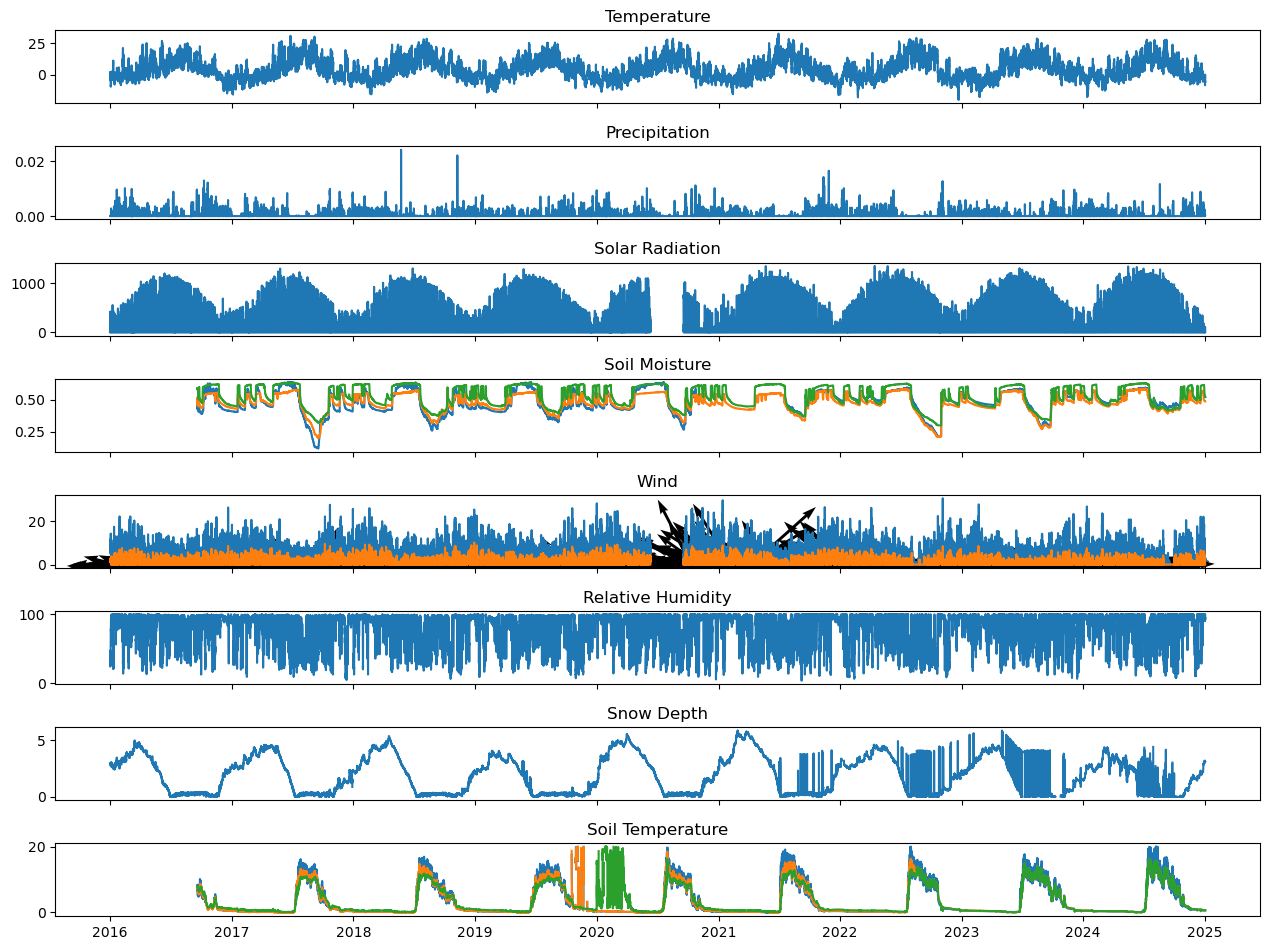

In [13]:
key = 'Paradise'
df_plot = boundary_SI_dict[key]
fig, ax = plt.subplots(8,1, sharex=True, figsize=(6.4*2, 4.8*2))
ax[0].set_title('Temperature')
ax[0].plot(df_plot[f'{key} Temperature (deg C)'])
ax[1].set_title('Precipitation')
ax[1].plot(df_plot[f'{key} Precipitation (m)'])
ax[2].set_title('Solar Radiation')
ax[2].plot(df_plot[f'{key}Wind Solar Radiation (W/m2)'])
ax[3].set_title('Soil Moisture')
ax[3].plot(df_plot[f'{key} Soil Moisture A (VWC)'])
ax[3].plot(df_plot[f'{key} Soil Moisture B (VWC)'])
ax[3].plot(df_plot[f'{key} Soil Moisture C (VWC)'])
ax[4].set_title('Wind')
# ax[4].plot(df_plot[f'{key}Wind Wind Speed Average (m/s)'])
ax[4].plot(df_plot[f'{key}Wind Wind Speed Maximum (m/s)'])
ax[4].plot(df_plot[f'{key}Wind Wind Speed Minimum (m/s)'])
ax[5].set_title('Relative Humidity')
ax[5].plot(df_plot[f'{key} Relative Humidity (%)'])
ax[6].set_title('Snow Depth')
ax[6].plot(df_plot[f'{key} Total Snow Depth (m)'])
ax[7].set_title('Soil Temperature')
ax[7].plot(df_plot[f'{key} Soil Temperature A (deg C)'])
ax[7].plot(df_plot[f'{key} Soil Temperature B (deg C)'])
ax[7].plot(df_plot[f'{key} Soil Temperature C (deg C)'])

# plot average wind speed and direction
# Extract wind direction and speed data
wind_direction = df_plot[f'{key}Wind Wind Direction (deg.)'].resample('1D').median()
wind_speed = df_plot[f'{key}Wind Wind Speed Average (m/s)'].resample('1D').median()

# Define arrow lengths based on wind speed
arrow_lengths = wind_speed * 25  # Adjust the scaling factor as needed

# Define arrow components
U = arrow_lengths * np.sin(np.radians(wind_direction))
V = arrow_lengths * np.cos(np.radians(wind_direction))

# Plot wind direction as arrows
ax[4].quiver(df_plot.resample('1D').median().index, 0, U, V, units='xy', scale=1)

# ax[8].set_xlim(datetime.datetime(2018,1,1),datetime.datetime(2019,1,1))
# ax[7].set_ylim(0,3)

# Adjust layout
fig.tight_layout()

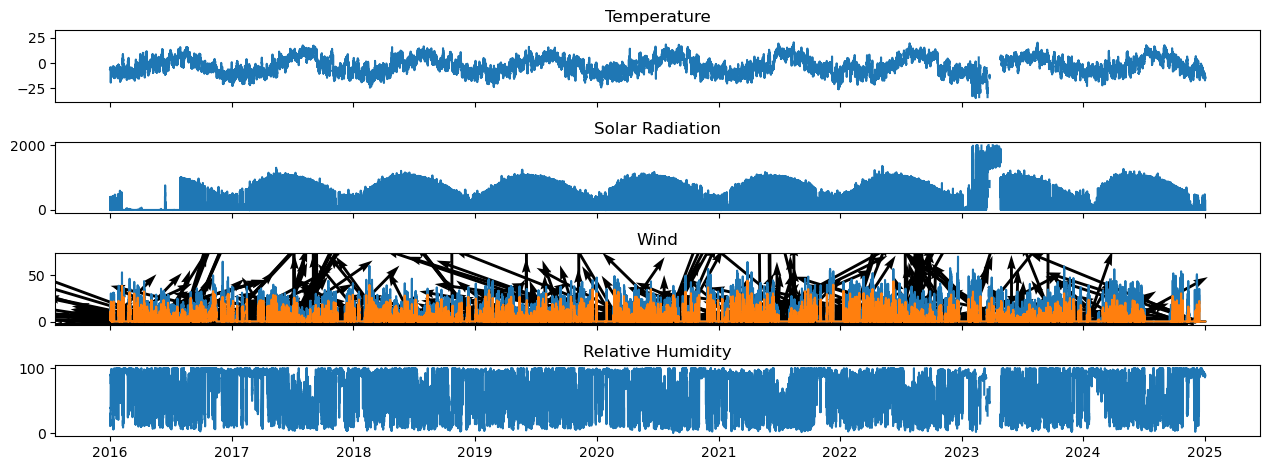

In [14]:
key = 'CampMuir'
df_plot = boundary_SI_dict[key]
fig, ax = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].set_title('Temperature')
ax[0].plot(df_plot[f'{key} Temperature (deg C)'])
ax[1].set_title('Solar Radiation')
ax[1].plot(df_plot[f'{key} Solar Radiation (W/m2)'])
# ax[1].plot(df_plot[f'{key} Net Solar (mJ/m2)'])
ax[2].set_title('Wind')
# ax[2].plot(df_plot[f'{key} Wind Speed Average (m/s)'])
ax[2].plot(df_plot[f'{key} Wind Speed Maximum (m/s)'])
ax[2].plot(df_plot[f'{key} Wind Speed Minimum (m/s)'])
ax[3].set_title('Relative Humidity')
ax[3].plot(df_plot[f'{key} Relative Humidity (%)'])

# plot average wind speed and direction
# Extract wind direction and speed data
wind_direction = df_plot[f'{key} Wind Direction (deg.)'].resample('1D').median()
wind_speed = df_plot[f'{key} Wind Speed Average (m/s)'].resample('1D').median()

# Define arrow lengths based on wind speed
arrow_lengths = wind_speed * 25  # Adjust the scaling factor as needed

# Define arrow components
U = arrow_lengths * np.sin(np.radians(wind_direction))
V = arrow_lengths * np.cos(np.radians(wind_direction))

# Plot wind direction as arrows
ax[2].quiver(df_plot.resample('1D').median().index, 0, U, V, units='xy', scale=1)

# ax[3].set_xlim(datetime.datetime(2018,8,1),datetime.datetime(2018,8,10))
# ax[0].set_ylim(-30,30)

# Adjust layout
fig.tight_layout()

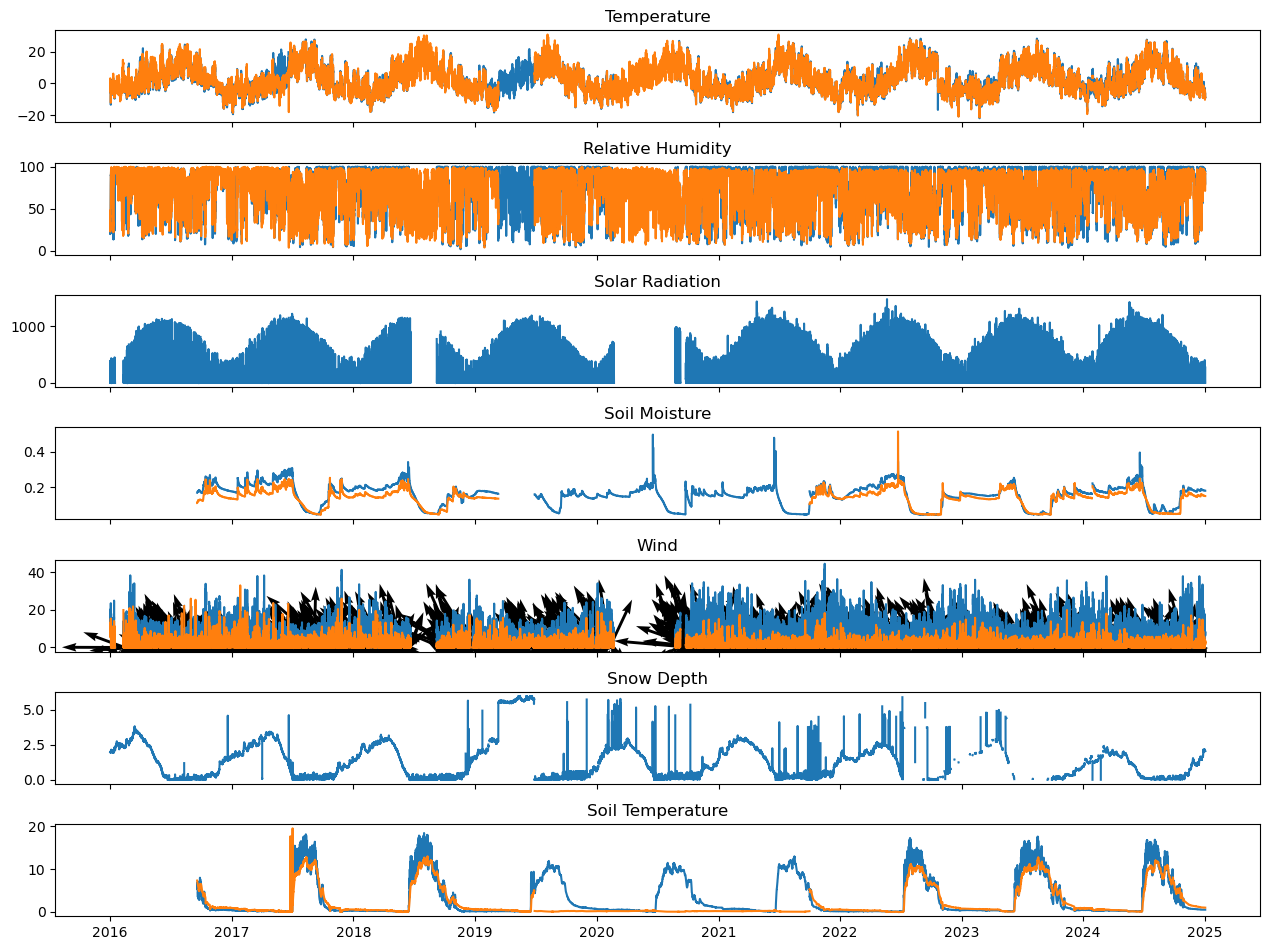

In [15]:
key = 'Sunrise'
df_plot = boundary_SI_dict[key]
fig, ax = plt.subplots(7,1, sharex=True, figsize=(6.4*2, 4.8*2))
ax[0].set_title('Temperature')
ax[0].plot(df_plot[f'{key}Upper Temperature (deg C)'])
ax[0].plot(df_plot[f'{key}Base Temperature (deg C)'])
ax[1].set_title('Relative Humidity')
ax[1].plot(df_plot[f'{key}Upper Relative Humidity (%)'])
ax[1].plot(df_plot[f'{key}Base Relative Humidity (%)'])
ax[2].set_title('Solar Radiation')
ax[2].plot(df_plot[f'{key}Upper Solar Radiation (W/m2)'])
ax[3].set_title('Soil Moisture')
ax[3].plot(df_plot[f'{key}Base Soil Moisture A (VWC)'])
ax[3].plot(df_plot[f'{key}Base Soil Moisture B (VWC)'])
ax[4].set_title('Wind')
# ax[4].plot(df_plot[f'{key}Wind Wind Speed Average (m/s)'])
ax[4].plot(df_plot[f'{key}Upper Wind Speed Maximum (m/s)'])
ax[4].plot(df_plot[f'{key}Upper Wind Speed Minimum (m/s)'])
ax[5].set_title('Snow Depth')
ax[5].plot(df_plot[f'{key}Base Total Snow Depth (m)'])
ax[6].set_title('Soil Temperature')
ax[6].plot(df_plot[f'{key}Base Soil Temperature A (deg C)'])
ax[6].plot(df_plot[f'{key}Base Soil Temperature B (deg C)'])

# plot average wind speed and direction --------------------------------------------------------------
# Extract wind direction and speed data
wind_direction = df_plot[f'{key}Upper Wind Direction (deg.)'].resample('1D').median()
wind_speed = df_plot[f'{key}Upper Wind Speed Average (m/s)'].resample('1D').median()

# Define arrow lengths based on wind speed
arrow_lengths = wind_speed * 25  # Adjust the scaling factor as needed

# Define arrow components
U = arrow_lengths * np.sin(np.radians(wind_direction))
V = arrow_lengths * np.cos(np.radians(wind_direction))

# Plot wind direction as arrows
ax[4].quiver(df_plot.resample('1D').median().index, 0, U, V, units='xy', scale=1)

# ax[8].set_xlim(datetime.datetime(2018,1,1),datetime.datetime(2019,1,1))

# ax[0].set_ylim(-30,30)

# Adjust layout
fig.tight_layout()

### Save the cleaned data

In [16]:
# save the data from approach 1
for key, df in std_SI_dict.items():
    df.to_csv('./data/weather/NWAC/{}/std_SI_{}.csv'.format(key,key))

In [17]:
# save the data from approach 2
for key, df in boundary_SI_dict.items():
    df.to_csv('./data/weather/NWAC/{}/SI_{}.csv'.format(key,key))

### Test to read the files

In [40]:
# set key, key is the station location
key = 'Paradise'
# read test df, replace index with 'time UTC' and convert to timestamp
df_test = pd.read_csv('./data/weather/NWAC/{}/SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
df_test

,ParadiseWind Solar Radiation (W/m2),ParadiseWind Wind Direction (deg.),Paradise Relative Humidity (%),Paradise Soil Moisture A (VWC),Paradise Soil Moisture B (VWC),Paradise Soil Moisture C (VWC),Paradise Soil Temperature A (deg C),Paradise Soil Temperature B (deg C),Paradise Soil Temperature C (deg C),SI time UTC,...,SI ParadiseWind Wind Speed Minimum (m/s),SI Paradise Precipitation (m),SI Paradise Total Snow Depth (m),SI Paradise Temperature (deg C),ParadiseWind Wind Speed Average (m/s),ParadiseWind Wind Speed Maximum (m/s),ParadiseWind Wind Speed Minimum (m/s),Paradise Precipitation (m),Paradise Total Snow Depth (m),Paradise Temperature (deg C)
time UTC,,,,,,,,,,,,,,,,,,,,,
2016-01-01 08:00:00,0.0,84.300,37.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.984496,11.426342,2.221789,0.000000,2.93624,-1.616667
2016-01-01 09:00:00,0.0,84.600,29.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.285744,6.982765,1.269594,0.000000,2.92354,-0.355556
2016-01-01 10:00:00,0.0,69.160,31.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.473501,7.617562,1.586992,0.000000,2.93878,-0.688889
2016-01-01 11:00:00,0.0,61.290,28.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.509264,7.934960,1.586992,0.000000,2.94640,-0.488889
2016-01-01 12:00:00,0.0,55.730,34.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.451149,6.030570,1.269594,0.000000,2.93624,-0.361111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 03:00:00,0.0,32.510,94.60,0.523,0.489,0.526,0.502,0.591,0.591,NaN,...,NaN,NaN,NaN,NaN,0.384007,2.209272,0.000000,0.000000,3.07848,-5.950000
2025-01-01 04:00:00,0.0,0.906,94.80,0.523,0.488,0.525,0.502,0.593,0.593,NaN,...,NaN,NaN,NaN,NaN,0.776956,2.840492,0.000000,0.000254,3.08102,-5.711111
2025-01-01 05:00:00,0.0,15.300,94.70,0.522,0.488,0.525,0.501,0.592,0.592,NaN,...,NaN,NaN,NaN,NaN,0.525272,1.893661,0.000000,0.000254,3.08356,-6.000000


/tmp/ipykernel_9817/1997718681.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax[4].quiver(df_test.resample('1D').median().index, 0, U, V, units='xy', scale=1)


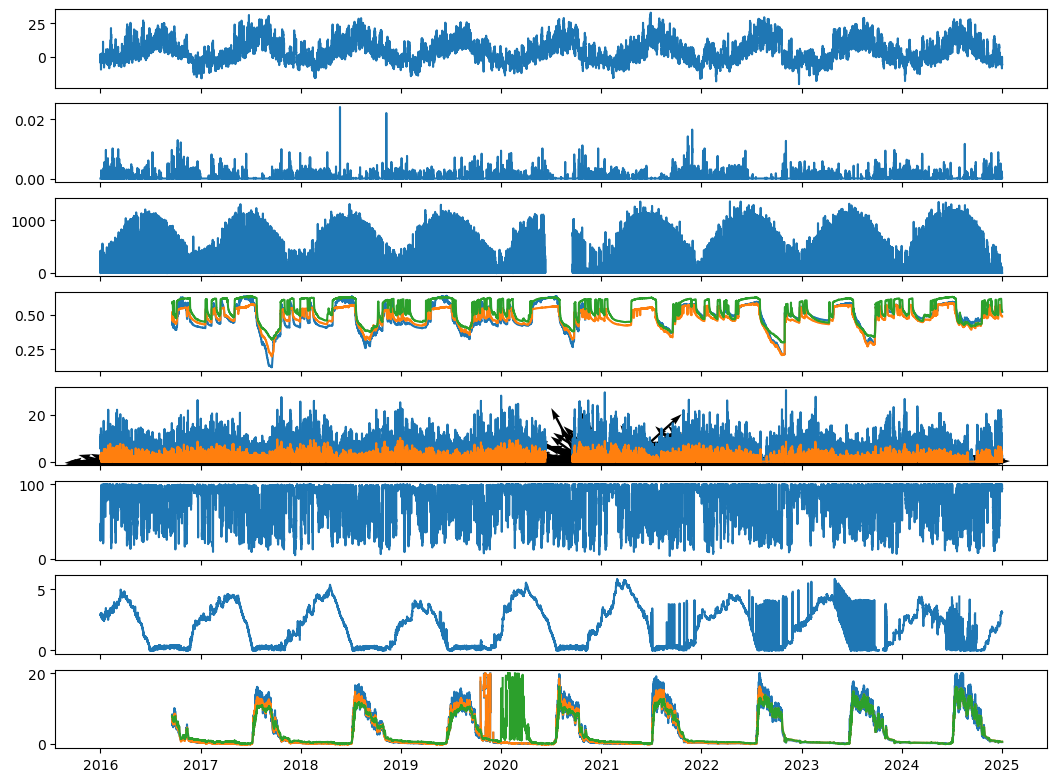

In [41]:
key = 'Paradise'
df_test = boundary_SI_dict[key]
fig, ax = plt.subplots(8,1, sharex=True, figsize=(6.4*2, 4.8*2))
ax[0].plot(df_test[f'{key} Temperature (deg C)'])
ax[1].plot(df_test[f'{key} Precipitation (m)'])
ax[2].plot(df_test[f'{key}Wind Solar Radiation (W/m2)'])
ax[3].plot(df_test[f'{key} Soil Moisture A (VWC)'])
ax[3].plot(df_test[f'{key} Soil Moisture B (VWC)'])
ax[3].plot(df_test[f'{key} Soil Moisture C (VWC)'])
# ax[4].plot(df_test[f'{key}Wind Wind Speed Average (m/s)'])
ax[4].plot(df_test[f'{key}Wind Wind Speed Maximum (m/s)'])
ax[4].plot(df_test[f'{key}Wind Wind Speed Minimum (m/s)'])
ax[5].plot(df_test[f'{key} Relative Humidity (%)'])
ax[6].plot(df_test[f'{key} Total Snow Depth (m)'])
ax[7].plot(df_test[f'{key} Soil Temperature A (deg C)'])
ax[7].plot(df_test[f'{key} Soil Temperature B (deg C)'])
ax[7].plot(df_test[f'{key} Soil Temperature C (deg C)'])

# plot average wind speed and direction
# Extract wind direction and speed data
wind_direction = df_test[f'{key}Wind Wind Direction (deg.)'].resample('1D').median()
wind_speed = df_test[f'{key}Wind Wind Speed Average (m/s)'].resample('1D').median()

# Define arrow lengths based on wind speed
arrow_lengths = wind_speed * 25  # Adjust the scaling factor as needed

# Define arrow components
U = arrow_lengths * np.sin(np.radians(wind_direction))
V = arrow_lengths * np.cos(np.radians(wind_direction))

# Plot wind direction as arrows
ax[4].quiver(df_test.resample('1D').median().index, 0, U, V, units='xy', scale=1)

# ax[8].set_xlim(datetime.datetime(2018,1,1),datetime.datetime(2019,1,1))
# ax[7].set_ylim(0,3)

## NWCC data

### Read data, built df for each station and convert time

There is a file containing all years but some of the parameters are missing therein. Therefore, I use the yearly files and merge them together.

In [57]:
# create an array with all NWAC stations
NWCC_sta_arr = np.unique([f.split('/')[-1] for f in sorted(glob.glob(path+'NWCC/*'))])
NWCC_sta_arr

array(['1085', '679'], dtype='<U4')

In [58]:
# Initialize an empty dictionary
result_dict = {}

# Loops over all stations in NWCC_sta_arr
for NWCC_sta in NWCC_sta_arr:
    li = []
    # Loops over all files of one station folder
    for NWCC_file in np.unique(sorted(glob.glob(path+f'NWCC/{NWCC_sta}/{NWCC_sta}_ALL_YEAR*.csv'))):
        # Extract sub-station name
        sub_sta = NWCC_file.split('/')[-1].split('_')[0]
        # Read CSV file into DataFrame
        df_year = pd.read_csv(NWCC_file, skiprows=3)
        # Replace -99.9 with nan
        df_year.replace(-99.9, np.nan, inplace=True)
        # Assuming 'Date' and 'Time' are strings
        df_year['DateTime'] = pd.to_datetime(df_year['Date'] + ' ' + df_year['Time'])
        # Now drop the original 'Date' and 'Time' columns
        df_year.drop(['Date', 'Time'], axis=1, inplace=True)
        # Get a list of column names containing 'BATT' and 'Unnamed'
        columns_to_drop = df_year.columns[df_year.columns.str.contains('Site Id|BATT|SAL|Unnamed')]
        # Drop columns containing 'BATT' and 'Unnamed: 25'
        df_year.drop(columns_to_drop, axis=1, inplace=True)
        # Remove trailing spaces from column names
        df_year.columns = df_year.columns.str.strip()
        # Replace consecutive spaces with a single space
        df_year.columns = df_year.columns.str.replace(r'\s+', ' ', regex=True)
        # Append DataFrame to list
        li.append(df_year)

    # Concatenate DataFrames in the list along axis 0 (rows), ignoring index, and create DataFrame df_NWCC
    df_NWCC = pd.concat(li, axis=0, ignore_index=True)
    # Set 'DateTime' column as index
    df_NWCC.set_index('DateTime', inplace=True)
    # Convert index to datetime, remove timezone information, adjust timezone by adding 8 hours (PST to UTC)
    df_NWCC.index = pd.to_datetime(df_NWCC.index).tz_localize(None) + pd.Timedelta(hours=8)
    # Rename index to 'time UTC'
    df_NWCC.index.names = ['time UTC']
    # Add df_NWCC to the dictionary, the key is the station/folder name
    result_dict[NWCC_sta] = df_NWCC


In [59]:
print(result_dict.keys())
result_dict['1085'].keys()

dict_keys(['1085', '679'])


Index(['WTEQ.I-1 (in)', 'PREC.I-1 (in)', 'TOBS.I-1 (degC)', 'SNWD.I-1 (in)',
       'SMS.I-1:-2 (pct) (silt)', 'SMS.I-1:-4 (pct) (silt)',
       'SMS.I-1:-8 (pct) (silt)', 'SMS.I-1:-20 (pct) (silt)',
       'SMS.I-1:-32 (pct) (silt)', 'STO.I-1:-2 (degC)', 'STO.I-1:-4 (degC)',
       'STO.I-1:-8 (degC)', 'STO.I-1:-20 (degC)', 'STO.I-1:-32 (degC)',
       'RDC.I-1:-2 (unit)', 'RDC.I-1:-4 (unit)', 'RDC.I-1:-8 (unit)',
       'RDC.I-1:-20 (unit)', 'RDC.I-1:-32 (unit)', 'TAVG.H-2 (degC)',
       'WDIRV.H-1 (degr)', 'WSPDX.H-1 (mph)', 'WSPDV.H-1 (mph)'],
      dtype='object')

### Convert units

In [60]:
# Initialize an empty dictionary to store converted DataFrames
result_SI_dict = {}

# Iterate over keys (station names) in result_dict
for key, df in result_dict.items():
    # Create a copy of the DataFrame to store the converted data
    df_si = df.copy()
    
    # Iterate over the columns in the DataFrame
    for col in df_si.columns:
        # Check if column header contains "(mph)"
        if '(mph)' in col:
            # Apply mph2ms conversion function and replace the column
            df_si[col.replace('(mph)', '(m/s)')] = mph2ms(df_si[col])
            # Drop the converter column
            df_si.drop(col, axis=1, inplace=True)
        # Check if column header contains "(pct)"
        elif '(pct)' in col:
            # Replace the column unit
            df_si[col.replace('(pct)', '(%)')] = df_si[col]
            # Drop the converter column
            df_si.drop(col, axis=1, inplace=True)
        # Check if column header contains '(")'
        elif '(in)' in col:
            # Apply inch2meters conversion function and replace the column
            df_si[col.replace('(in)', '(m)')] = inch2meters(df_si[col])
            # Drop the converter column
            df_si.drop(col, axis=1, inplace=True)

    
    # Add the converted DataFrame to the result_SI_dict
    result_SI_dict[key] = df_si


In [61]:
result_SI_dict['1085'].keys()

Index(['TOBS.I-1 (degC)', 'STO.I-1:-2 (degC)', 'STO.I-1:-4 (degC)',
       'STO.I-1:-8 (degC)', 'STO.I-1:-20 (degC)', 'STO.I-1:-32 (degC)',
       'RDC.I-1:-2 (unit)', 'RDC.I-1:-4 (unit)', 'RDC.I-1:-8 (unit)',
       'RDC.I-1:-20 (unit)', 'RDC.I-1:-32 (unit)', 'TAVG.H-2 (degC)',
       'WDIRV.H-1 (degr)', 'WTEQ.I-1 (m)', 'PREC.I-1 (m)', 'SNWD.I-1 (m)',
       'SMS.I-1:-2 (%) (silt)', 'SMS.I-1:-4 (%) (silt)',
       'SMS.I-1:-8 (%) (silt)', 'SMS.I-1:-20 (%) (silt)',
       'SMS.I-1:-32 (%) (silt)', 'WSPDX.H-1 (m/s)', 'WSPDV.H-1 (m/s)'],
      dtype='object')

### Delete outliers

There are two ways to do so.

1.) Eigher, you make sure that all the parameters which cannot be negative (all except from the Temperature) are 0 or larger. In a second step, you drop all values larger or smaller than 3 x std of the whole time series.

2.) You define a acceptable max and min value for each parameter. This gives you more flexibility but also can cause problems if your station is located in a completely different environmnet. Additionally, it takes some time to define meaningful boundaries.

#### 1.) Approach: drop the negative values and keep only values within 3xstd

In [62]:
# these parameters have to be 0 or positive
# Initialize an empty dictionary to store converted DataFrames
positiv_SI_dict = {}

# Iterate over keys (station names) in result_dict
for key, df in result_SI_dict.items():
    # Create a copy of the DataFrame to store the converted data
    df_positiv = df.copy()
    
    # Iterate over the columns in the DataFrame
    for col in df_positiv.columns:
        # Check if the column name contains "(deg C)"
        if '(degC)' not in col:
            # Replace negative values with NaN
            df_positiv.loc[df_positiv[col] < 0, col] = np.nan
    
    # Add the converted DataFrame to the positiv_SI_dict
    positiv_SI_dict[key] = df_positiv


In [63]:
# Initialize an empty dictionary to store DataFrames with standard deviation check
std_SI_dict = {}

# Iterate over keys (station names) in result_dict
for key, df in positiv_SI_dict.items():
    # Create a copy of the DataFrame
    df_std = df.copy()
    
    # Iterate over the columns in the DataFrame
    for col in df_std.columns:
        # Replace values larger or smaller than 3 times the std with NaN
        df_std.loc[(df_std[col] > 3 * df_std[col].std()) | (df_std[col] < -3 * df_std[col].std()), col] = np.nan
    
    # Add the modified DataFrame to the std_SI_dict
    std_SI_dict[key] = df_std


In [64]:
for key, df in std_SI_dict.items():
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Calculate and print the maximum value of the column
        max_value = round(df[column].max(),3)
        # Calculate and print the minimum value of the column
        min_value = round(df[column].min(),3)
        
        print(f"{key} - {column}: Min :{min_value}, Max: {max_value}")


1085 - TOBS.I-1 (degC): Min :-21.3, Max: 21.4
1085 - STO.I-1:-2 (degC): Min :-1.8, Max: 12.7
1085 - STO.I-1:-4 (degC): Min :-1.8, Max: 12.0
1085 - STO.I-1:-8 (degC): Min :-1.8, Max: 11.2
1085 - STO.I-1:-20 (degC): Min :-1.8, Max: 7.6
1085 - STO.I-1:-32 (degC): Min :-0.1, Max: 5.6
1085 - RDC.I-1:-2 (unit): Min :3.16, Max: 20.14
1085 - RDC.I-1:-4 (unit): Min :3.01, Max: 20.45
1085 - RDC.I-1:-8 (unit): Min :6.5, Max: 22.07
1085 - RDC.I-1:-20 (unit): Min :0.21, Max: 20.45
1085 - RDC.I-1:-32 (unit): Min :0.33, Max: 25.51
1085 - TAVG.H-2 (degC): Min :-21.1, Max: 21.4
1085 - WDIRV.H-1 (degr): Min :0.0, Max: 308.0
1085 - WTEQ.I-1 (m): Min :0.0, Max: 2.197
1085 - PREC.I-1 (m): Min :0.0, Max: 2.385
1085 - SNWD.I-1 (m): Min :0.0, Max: 4.394
1085 - SMS.I-1:-2 (%) (silt): Min :0.0, Max: 35.4
1085 - SMS.I-1:-4 (%) (silt): Min :0.0, Max: 34.4
1085 - SMS.I-1:-8 (%) (silt): Min :0.0, Max: 22.4
1085 - SMS.I-1:-20 (%) (silt): Min :0.0, Max: 14.7
1085 - SMS.I-1:-32 (%) (silt): Min :0.0, Max: 15.4
1085 - W

#### 2.) Approach: define the boundaries manually

In [65]:
# Initialize an empty dictionary to store converted DataFrames
boundary_SI_dict = {}

# Iterate over keys (station names) in result_dict
for key, df in result_SI_dict.items():
    # Create a copy of the DataFrame to store the converted data
    df_boundary = df.copy()
    
    # Iterate over the columns in the DataFrame
    for col in df_boundary.columns:
        # Check if column header contains "Temperature"
        if '(degC)' in col:
            # Drop values larger than 30 and smaller than -30
            df_boundary.loc[(df_boundary[col] > 35) | (df_boundary[col] < -35), col] = np.nan

        elif 'SAL' in col:
            # Drop values larger than 2
            df_boundary.loc[(df_boundary[col] > 0.5) | (df_boundary[col] < 0), col] = np.nan

        elif 'WDIRV' in col:
            # Drop values larger than 360
            df_boundary.loc[(df_boundary[col] > 360) | (df_boundary[col] < 0), col] = np.nan

        elif 'RDC' in col:
            # Drop values larger than 100
            df_boundary.loc[(df_boundary[col] > 50) | (df_boundary[col] < 0), col] = np.nan

        elif 'WSPD' in col:
            # Drop values larger than 80
            df_boundary.loc[(df_boundary[col] > 80) | (df_boundary[col] < 0), col] = np.nan

        elif 'SMS' in col:
            # Drop values larger than 1
            df_boundary.loc[(df_boundary[col] > 100) | (df_boundary[col] < 0), col] = np.nan

        elif 'PREC' in col:
            # Drop values larger than 0.1
            df_boundary.loc[(df_boundary[col] > 5) | (df_boundary[col] < 0), col] = np.nan

        elif 'SNWD' in col:
            # Drop values larger than 10
            df_boundary.loc[(df_boundary[col] > 6) | (df_boundary[col] < 0), col] = np.nan

        elif 'WTEQ' in col:
            # Drop values larger than 5
            df_boundary.loc[(df_boundary[col] > 5) | (df_boundary[col] < 0), col] = np.nan
            
    # Add the converted DataFrame to the boundary_SI_dict
    boundary_SI_dict[key] = df_boundary


In [66]:
for key, df in boundary_SI_dict.items():
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Calculate and print the maximum value of the column
        max_value = round(df[column].max(),3)
        # Calculate and print the minimum value of the column
        min_value = round(df[column].min(),3)

        print(f"{key} - {column}: Max: {max_value}, Min :{min_value}")


1085 - TOBS.I-1 (degC): Max: 32.8, Min :-21.5
1085 - STO.I-1:-2 (degC): Max: 18.0, Min :-1.8
1085 - STO.I-1:-4 (degC): Max: 15.1, Min :-1.8
1085 - STO.I-1:-8 (degC): Max: 14.0, Min :-1.8
1085 - STO.I-1:-20 (degC): Max: 24.5, Min :-1.8
1085 - STO.I-1:-32 (degC): Max: 7.2, Min :-0.1
1085 - RDC.I-1:-2 (unit): Max: 40.83, Min :3.16
1085 - RDC.I-1:-4 (unit): Max: 43.34, Min :3.01
1085 - RDC.I-1:-8 (unit): Max: 42.14, Min :6.5
1085 - RDC.I-1:-20 (unit): Max: 48.55, Min :0.21
1085 - RDC.I-1:-32 (unit): Max: 43.44, Min :0.33
1085 - TAVG.H-2 (degC): Max: 32.2, Min :-21.1
1085 - WDIRV.H-1 (degr): Max: 360.0, Min :0.0
1085 - WTEQ.I-1 (m): Max: 2.875, Min :0.0
1085 - PREC.I-1 (m): Max: 4.455, Min :0.0
1085 - SNWD.I-1 (m): Max: 5.791, Min :0.0
1085 - SMS.I-1:-2 (%) (silt): Max: 40.6, Min :0.0
1085 - SMS.I-1:-4 (%) (silt): Max: 40.7, Min :0.0
1085 - SMS.I-1:-8 (%) (silt): Max: 40.7, Min :0.0
1085 - SMS.I-1:-20 (%) (silt): Max: 41.1, Min :0.0
1085 - SMS.I-1:-32 (%) (silt): Max: 40.7, Min :0.0
1085 - 

### Visualization

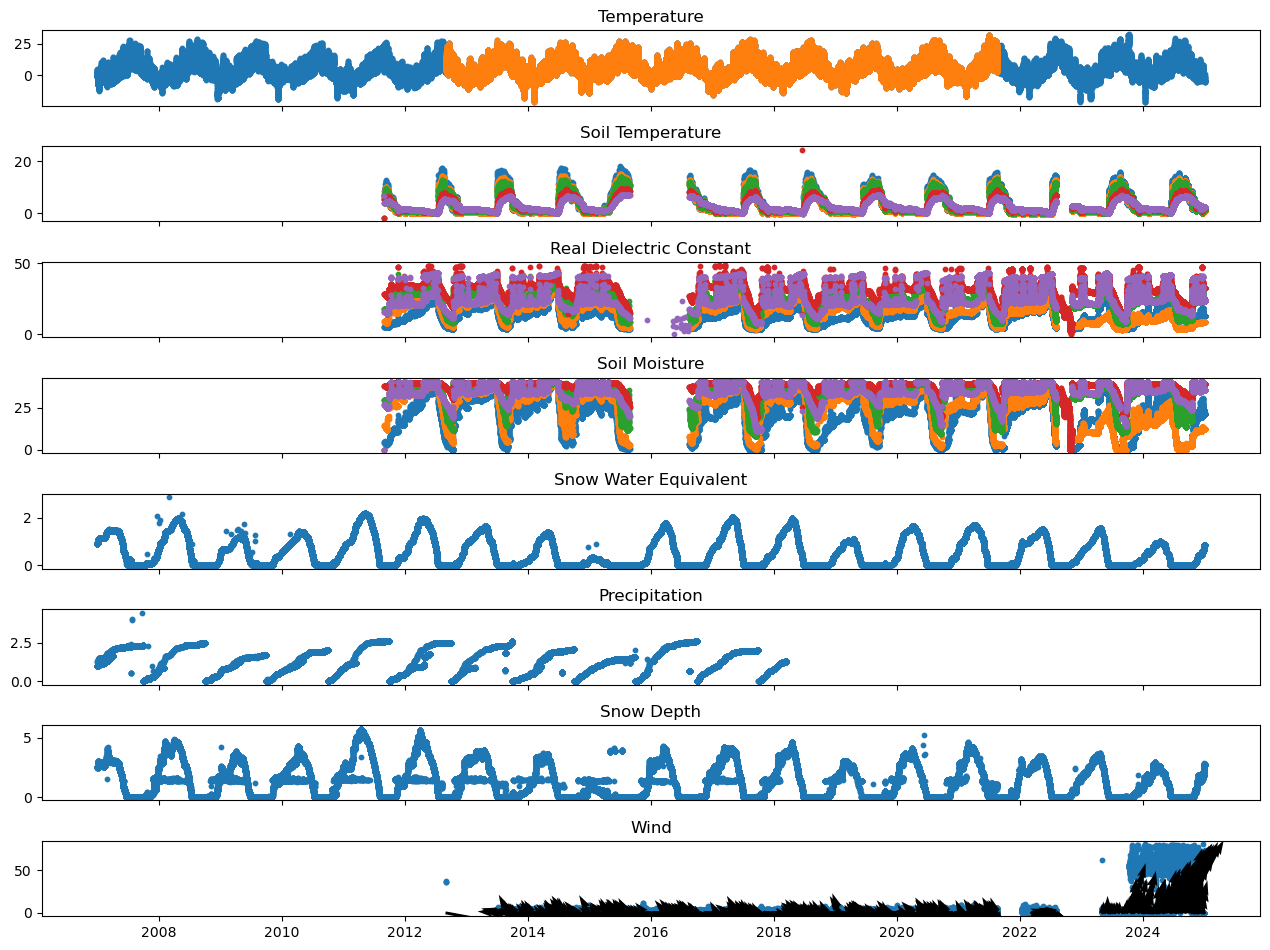

In [67]:
key = '1085'
df_plot = boundary_SI_dict[key]
fig, ax = plt.subplots(8,1, sharex=True, figsize=(6.4*2, 4.8*2))
ax[0].set_title('Temperature')
ax[0].scatter(df_plot.index, df_plot['TOBS.I-1 (degC)'], s=10)
ax[0].scatter(df_plot.index, df_plot['TAVG.H-2 (degC)'], s=10)
ax[1].set_title('Soil Temperature')
ax[1].scatter(df_plot.index, df_plot['STO.I-1:-2 (degC)'], s=10)
ax[1].scatter(df_plot.index, df_plot['STO.I-1:-4 (degC)'], s=10)
ax[1].scatter(df_plot.index, df_plot['STO.I-1:-8 (degC)'], s=10)
ax[1].scatter(df_plot.index, df_plot['STO.I-1:-20 (degC)'], s=10)
ax[1].scatter(df_plot.index, df_plot['STO.I-1:-32 (degC)'], s=10)
ax[2].set_title('Real Dielectric Constant')
ax[2].scatter(df_plot.index, df_plot['RDC.I-1:-2 (unit)'], s=10)
ax[2].scatter(df_plot.index, df_plot['RDC.I-1:-4 (unit)'], s=10)
ax[2].scatter(df_plot.index, df_plot['RDC.I-1:-8 (unit)'], s=10)
ax[2].scatter(df_plot.index, df_plot['RDC.I-1:-20 (unit)'], s=10)
ax[2].scatter(df_plot.index, df_plot['RDC.I-1:-32 (unit)'], s=10)
ax[3].set_title('Soil Moisture')
ax[3].scatter(df_plot.index, df_plot['SMS.I-1:-2 (%) (silt)'], s=10)
ax[3].scatter(df_plot.index, df_plot['SMS.I-1:-4 (%) (silt)'], s=10)
ax[3].scatter(df_plot.index, df_plot['SMS.I-1:-8 (%) (silt)'], s=10)
ax[3].scatter(df_plot.index, df_plot['SMS.I-1:-20 (%) (silt)'], s=10)
ax[3].scatter(df_plot.index, df_plot['SMS.I-1:-32 (%) (silt)'], s=10)
ax[4].set_title('Snow Water Equivalent')
ax[4].scatter(df_plot.index, df_plot['WTEQ.I-1 (m)'], s=10)
ax[5].set_title('Precipitation')
ax[5].scatter(df_plot.index, df_plot['PREC.I-1 (m)'], s=10)
ax[6].set_title('Snow Depth')
ax[6].scatter(df_plot.index, df_plot['SNWD.I-1 (m)'], s=10)
ax[7].set_title('Wind')
ax[7].scatter(df_plot.index, df_plot['WSPDX.H-1 (m/s)'], s=10)
# ax[7].scatter(df_plot.index, df_plot['WSPDV.H-1 (m/s)'], s=10)
# ax[7].scatter(df_plot.index, df_plot['WDIRV.H-1 (degr)'], s=10)


# plot average wind speed and direction
# Extract wind direction and speed data
wind_direction = df_plot['WDIRV.H-1 (degr)'].resample('1D').median()
wind_speed = df_plot['WSPDV.H-1 (m/s)'].resample('1D').median()

# Define arrow lengths based on wind speed
arrow_lengths = wind_speed * 50  # Adjust the scaling factor as needed

# Define arrow components
U = arrow_lengths * np.sin(np.radians(wind_direction))
V = arrow_lengths * np.cos(np.radians(wind_direction))

# Plot wind direction as arrows
ax[7].quiver(df_plot.resample('1D').median().index, 0, U, V, units='xy', scale=1)

# ax[8].set_xlim(datetime

# Adjust layout
fig.tight_layout()

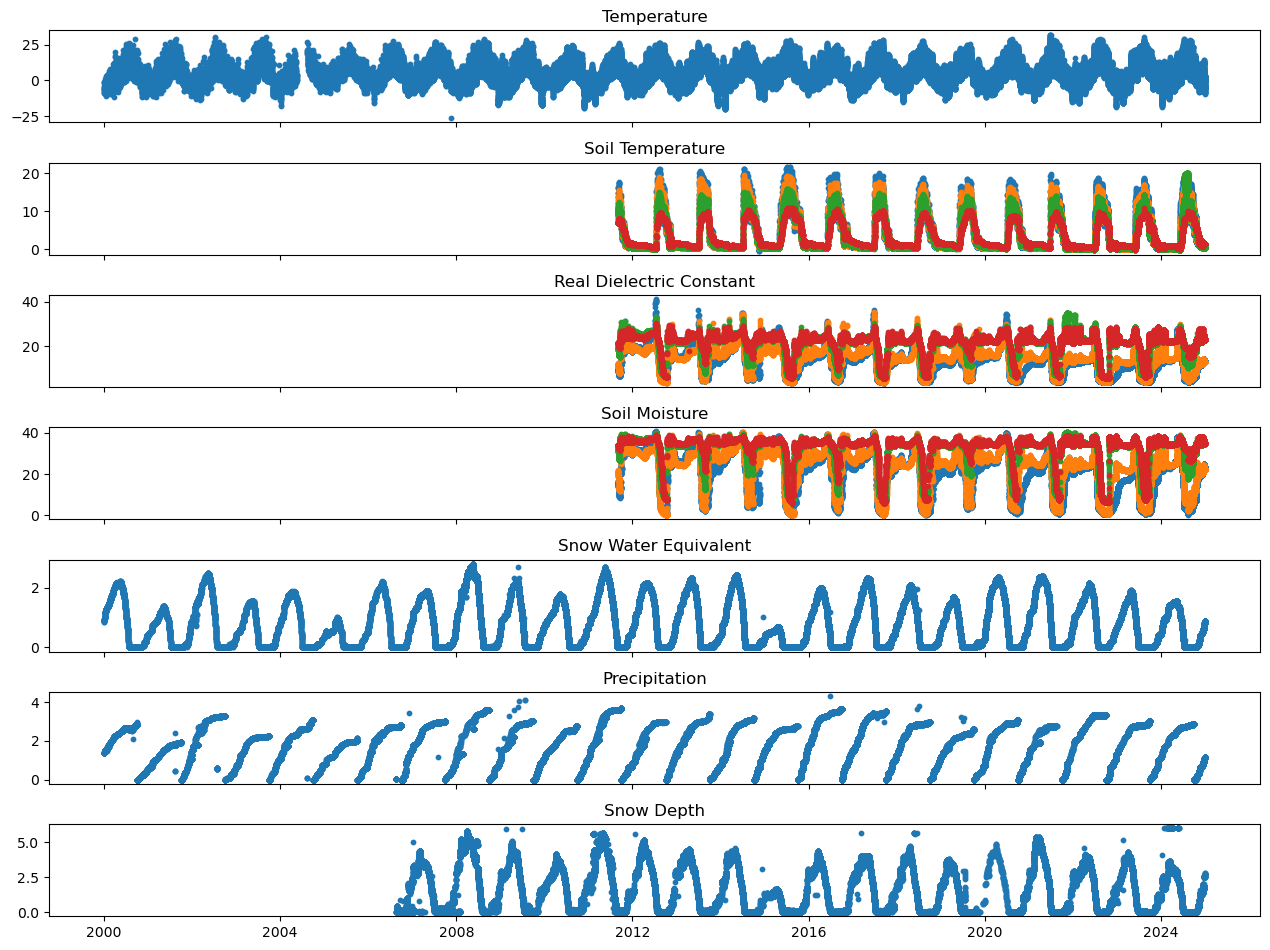

In [69]:
key = '679'
df_plot = boundary_SI_dict[key]
fig, ax = plt.subplots(7,1, sharex=True, figsize=(6.4*2, 4.8*2))
ax[0].scatter(df_plot.index, df_plot['TOBS.I-1 (degC)'], s=10)
ax[0].set_title('Temperature')
ax[1].scatter(df_plot.index, df_plot['STO.I-1:-2 (degC)'], s=10)
ax[1].scatter(df_plot.index, df_plot['STO.I-1:-4 (degC)'], s=10)
ax[1].scatter(df_plot.index, df_plot['STO.I-1:-8 (degC)'], s=10)
ax[1].scatter(df_plot.index, df_plot['STO.I-1:-20 (degC)'], s=10)
ax[1].set_title('Soil Temperature')
ax[2].scatter(df_plot.index, df_plot['RDC.I-1:-2 (unit)'], s=10)
ax[2].scatter(df_plot.index, df_plot['RDC.I-1:-4 (unit)'], s=10)
ax[2].scatter(df_plot.index, df_plot['RDC.I-1:-8 (unit)'], s=10)
ax[2].scatter(df_plot.index, df_plot['RDC.I-1:-20 (unit)'], s=10)
ax[2].set_title('Real Dielectric Constant')
ax[3].scatter(df_plot.index, df_plot['SMS.I-1:-2 (%) (silt)'], s=10)
ax[3].scatter(df_plot.index, df_plot['SMS.I-1:-4 (%) (silt)'], s=10)
ax[3].scatter(df_plot.index, df_plot['SMS.I-1:-8 (%) (silt)'], s=10)
ax[3].scatter(df_plot.index, df_plot['SMS.I-1:-20 (%) (silt)'], s=10)
ax[3].set_title('Soil Moisture')
ax[4].scatter(df_plot.index, df_plot['WTEQ.I-1 (m)'], s=10)
ax[4].set_title('Snow Water Equivalent')
ax[5].scatter(df_plot.index, df_plot['PREC.I-1 (m)'], s=10)
ax[5].set_title('Precipitation')
ax[6].scatter(df_plot.index, df_plot['SNWD.I-1 (m)'], s=10)
ax[6].set_title('Snow Depth')

# ax[6].set_xlim(datetime.datetime(2018,1,1),datetime.datetime(2019,1,1))

# Adjust layout
fig.tight_layout()

### Save the cleaned data

In [70]:
# save the data from approach 1
for key, df in std_SI_dict.items():
    df.to_csv('./data/weather/NWCC/{}/std_SI_{}.csv'.format(key,key))

In [71]:
# save the data from approach 2
for key, df in boundary_SI_dict.items():
    df.to_csv('./data/weather/NWCC/{}/SI_{}.csv'.format(key,key))

### Test to read the files

In [72]:
# set key, key is the station location
key = '679'
# read test df, replace index with 'time UTC' and convert to timestamp
df_test = pd.read_csv('./data/weather/NWCC/{}/std_SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
df_test

,TOBS.I-1 (degC),STO.I-1:-2 (degC),STO.I-1:-4 (degC),STO.I-1:-8 (degC),STO.I-1:-20 (degC),RDC.I-1:-2 (unit),RDC.I-1:-4 (unit),RDC.I-1:-8 (unit),RDC.I-1:-20 (unit),WTEQ.I-1 (m),PREC.I-1 (m),SNWD.I-1 (m),SMS.I-1:-2 (%) (silt),SMS.I-1:-4 (%) (silt),SMS.I-1:-8 (%) (silt),SMS.I-1:-20 (%) (silt)
time UTC,,,,,,,,,,,,,,,,
2000-01-01 08:00:00,-3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.84582,1.37160,NaN,NaN,NaN,NaN,NaN
2000-01-01 14:00:00,-4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.85344,1.37160,NaN,NaN,NaN,NaN,NaN
2000-01-01 20:00:00,-5.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.86868,1.38176,NaN,NaN,NaN,NaN,NaN
2000-01-02 02:00:00,-5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.87884,1.38684,NaN,NaN,NaN,NaN,NaN
2000-01-02 08:00:00,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.88900,1.38430,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 03:00:00,-5.7,0.4,0.4,0.6,1.4,13.28,12.76,NaN,NaN,0.87630,1.15062,NaN,22.8,21.8,NaN,NaN
2025-01-01 04:00:00,-5.8,0.4,0.4,0.6,1.4,13.28,12.76,NaN,NaN,0.87630,1.15062,NaN,22.8,21.8,NaN,NaN
2025-01-01 05:00:00,-5.8,0.4,0.4,0.6,1.4,13.28,12.76,NaN,NaN,0.87630,1.15062,NaN,22.8,21.8,NaN,NaN


## river data
The river data have two parameters (discharge & gageheight). Both are saved in individual txt-files.

### Read data, built df for each station and convert time

In [53]:
# Create an array with all rivers
river_arr = np.unique([f.split('/')[-1].split('_')[0] for f in sorted(glob.glob(path+'river/*'))])
river_arr

array(['nisqually', 'puyallup'], dtype='<U9')

In [54]:
# Initialize an empty dictionary
river_dict = {}

for river in river_arr:
    print(river)
    for i,file in enumerate(np.unique(sorted(glob.glob(path+f'river/{river}/{river}*.txt')))):

        with open(file, 'r') as f:
            # Initialize a flag to indicate when to capture the next line
            capture_next_line = False

            # Read through the file line by line
            for line in f:
                # Check if the current line contains "Parameter Description"
                if 'Parameter Description' in line:
                    # Set the flag to True to capture the next line
                    capture_next_line = True
                elif capture_next_line:
                    # Extract the parameter from the next line starting from position 3
                    param = line.strip()[27:]
                    # Reset the flag
                    capture_next_line = False
                    # Break out of the loop since we found the parameter
                    break
        print(param)
    
        df_river = pd.read_csv(file, comment='#', header=1, delimiter='	', 
                               usecols=[2,4], names=['datetime', str(param)])
        # Convert 'datetime' column to datetime objects and set timezone
        df_river.index = pd.to_datetime(df_river['datetime']).apply(lambda x: x + pd.Timedelta(hours=8) 
                                                                    if x.tzinfo == 'PST' 
                                                                    else x + pd.Timedelta(hours=7))
        # Rename index to 'time UTC'
        df_river.index.names = ['time UTC']
        # Drop the column 'datetime'
        df_river = df_river.drop('datetime',axis=1)

        # Join the parameters into one df_sta
        if i ==0:
            df_sta = df_river.copy()
        else:
            df_sta = df_sta.join(df_river)

    # Store the DataFrame in the dictionary
    river_dict[river] = df_sta

nisqually
Discharge, cubic feet per second
Gage height, feet
puyallup
Discharge, cubic feet per second
Gage height, feet


In [55]:
river_dict['puyallup']

,"Discharge, cubic feet per second","Gage height, feet"
time UTC,,
2000-01-01 07:00:00,496.0,NaN
2000-01-01 07:15:00,496.0,NaN
2000-01-01 07:30:00,480.0,NaN
2000-01-01 07:45:00,485.0,NaN
2000-01-01 08:00:00,485.0,NaN
...,...,...
2025-02-07 05:45:00,188.0,3.78
2025-02-07 06:00:00,191.0,3.79
2025-02-07 06:15:00,194.0,3.80


### Convert units

In [56]:
# Initialize an empty dictionary to store converted DataFrames
river_SI_dict = {}

# Iterate over keys (station names) in result_dict
for key, df in river_dict.items():
    # Create a copy of the DataFrame to store the converted data
    df_si = df.copy()
    
    # Iterate over the columns in the DataFrame
    for col in df_si.columns:
        # Check if column header contains "(mph)"
        if 'cubic feet per second' in col:
            # Apply cfs2cms conversion function and replace the column
            df_si[col.replace('cubic feet per second', '(m/s)')] = cfs2cms(df_si[col])
            # Drop the converter column
            df_si.drop(col, axis=1, inplace=True)
        # Check if column header contains '(")'
        elif 'feet' in col:
            # Apply feet2meters conversion function and replace the column
            df_si[col.replace('feet', '(m)')] = feet2meters(df_si[col])
            # Drop the converter column
            df_si.drop(col, axis=1, inplace=True)
    
    # Add the converted DataFrame to the result_SI_dict
    river_SI_dict[key] = df_si


In [57]:
river_SI_dict['puyallup']

,"Discharge, (m/s)","Gage height, (m)"
time UTC,,
2000-01-01 07:00:00,14.045133,NaN
2000-01-01 07:15:00,14.045133,NaN
2000-01-01 07:30:00,13.592064,NaN
2000-01-01 07:45:00,13.733648,NaN
2000-01-01 08:00:00,13.733648,NaN
...,...,...
2025-02-07 05:45:00,5.323558,1.152144
2025-02-07 06:00:00,5.408509,1.155192
2025-02-07 06:15:00,5.493459,1.158240


### Visualization

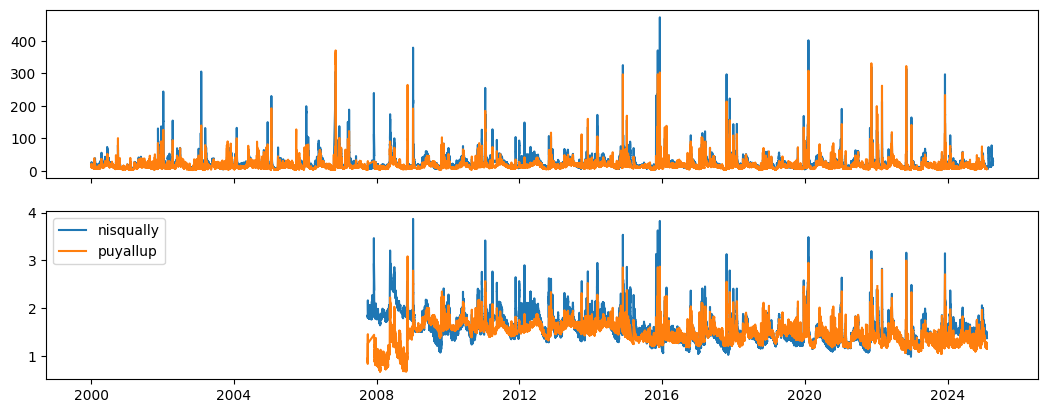

In [59]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
for key, df_plot in river_SI_dict.items():
    ax[0].plot(df_plot['Discharge, (m/s)'], label=key)
    ax[1].plot(df_plot['Gage height, (m)'], label=key)
plt.legend(loc='upper left')
plt.show()

### Save the cleaned data

In [60]:
# save the data from approach 1
for key, df in river_SI_dict.items():
    df.to_csv('./data/weather/river/{}/SI_{}.csv'.format(key,key))

### Test to read the files

In [61]:
# set key, key is the station location
key = 'nisqually'
# read test df, replace index with 'time UTC' and convert to timestamp
df_test = pd.read_csv('./data/weather/river/{}/SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
df_test

,"Discharge, (m/s)","Gage height, (m)"
time UTC,,
2000-01-01 08:00:00,21.265917,NaN
2000-01-01 08:15:00,20.982749,NaN
2000-01-01 08:30:00,20.982749,NaN
2000-01-01 08:45:00,20.982749,NaN
2000-01-01 09:00:00,20.982749,NaN
...,...,...
2025-04-10 16:00:00,30.582144,NaN
2025-04-10 16:15:00,30.865312,NaN
2025-04-10 16:30:00,31.148480,NaN


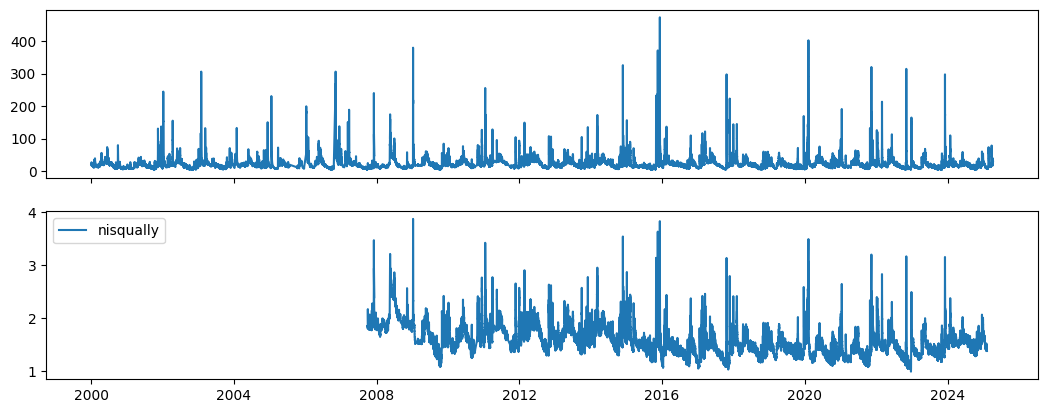

In [62]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(df_test['Discharge, (m/s)'], label=key)
ax[1].plot(df_test['Gage height, (m)'], label=key)
plt.legend(loc='upper left')
plt.show()

## Load and plot

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from difflib import SequenceMatcher

In [2]:
!ls ./data/weather/NWAC

CampMuir  Paradise  Sunrise


In [3]:
# Set key for Paradise, read the CSV file, and replace index with 'time UTC' and convert to timestamp
key = 'Paradise'
df_NWAC_Paradise = pd.read_csv(f'./data/weather/NWAC/{key}/SI_{key}.csv', index_col='time UTC', parse_dates=True)
print(df_NWAC_Paradise.columns)

# Set key for CampMuir, read the CSV file, and replace index with 'time UTC' and convert to timestamp
key = 'CampMuir'
df_NWAC_CampMuir = pd.read_csv(f'./data/weather/NWAC/{key}/SI_{key}.csv', index_col='time UTC', parse_dates=True)
print(df_NWAC_CampMuir.columns)

# Set key for Sunrise, read the CSV file, and replace index with 'time UTC' and convert to timestamp
key = 'Sunrise'
df_NWAC_Sunrise = pd.read_csv(f'./data/weather/NWAC/{key}/SI_{key}.csv', index_col='time UTC', parse_dates=True)
print(df_NWAC_Sunrise.columns)

# set key, key is the station location
key = '679'
# read test df, replace index with 'time UTC' and convert to timestamp
df_NWCC_679 = pd.read_csv('./data/weather/NWCC/{}/SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
print(df_NWCC_679.columns)

# set key, key is the station location
key = '1085'
# read test df, replace index with 'time UTC' and convert to timestamp
df_NWCC_1085 = pd.read_csv('./data/weather/NWCC/{}/SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
print(df_NWCC_1085.columns)

# set key, key is the station location
key = 'nisqually'
# read test df, replace index with 'time UTC' and convert to timestamp
df_river_nisqually = pd.read_csv('./data/weather/river/{}/SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
print(df_river_nisqually.columns)

# set key, key is the station location
key = 'puyallup'
# read test df, replace index with 'time UTC' and convert to timestamp
df_river_puyallup = pd.read_csv('./data/weather/river/{}/SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
print(df_river_puyallup.columns)


Index(['ParadiseWind Solar Radiation (W/m2)',
       'ParadiseWind Wind Direction (deg.)', 'Paradise Relative Humidity (%)',
       'Paradise Soil Moisture A (VWC)', 'Paradise Soil Moisture B (VWC)',
       'Paradise Soil Moisture C (VWC)', 'Paradise Soil Temperature A (deg C)',
       'Paradise Soil Temperature B (deg C)',
       'Paradise Soil Temperature C (deg C)',
       'ParadiseWind Wind Speed Average (m/s)',
       'ParadiseWind Wind Speed Maximum (m/s)',
       'ParadiseWind Wind Speed Minimum (m/s)', 'Paradise Precipitation (m)',
       'Paradise Total Snow Depth (m)', 'Paradise Temperature (deg C)'],
      dtype='object')
Index(['CampMuir Net Solar (mJ/m2)', 'CampMuir Relative Humidity (%)',
       'CampMuir Solar Radiation (W/m2)', 'CampMuir Wind Direction (deg.)',
       'CampMuir Temperature (deg C)', 'CampMuir Wind Speed Average (m/s)',
       'CampMuir Wind Speed Maximum (m/s)',
       'CampMuir Wind Speed Minimum (m/s)'],
      dtype='object')
Index(['SunriseBase Relat

### Station plots
#### NWAC

Index(['ParadiseWind Solar Radiation (W/m2)',
       'ParadiseWind Wind Direction (deg.)', 'Paradise Relative Humidity (%)',
       'Paradise Soil Moisture A (VWC)', 'Paradise Soil Moisture B (VWC)',
       'Paradise Soil Moisture C (VWC)', 'Paradise Soil Temperature A (deg C)',
       'Paradise Soil Temperature B (deg C)',
       'Paradise Soil Temperature C (deg C)',
       'ParadiseWind Wind Speed Average (m/s)',
       'ParadiseWind Wind Speed Maximum (m/s)',
       'ParadiseWind Wind Speed Minimum (m/s)', 'Paradise Precipitation (m)',
       'Paradise Total Snow Depth (m)', 'Paradise Temperature (deg C)'],
      dtype='object')


(19936.0, 19967.0)

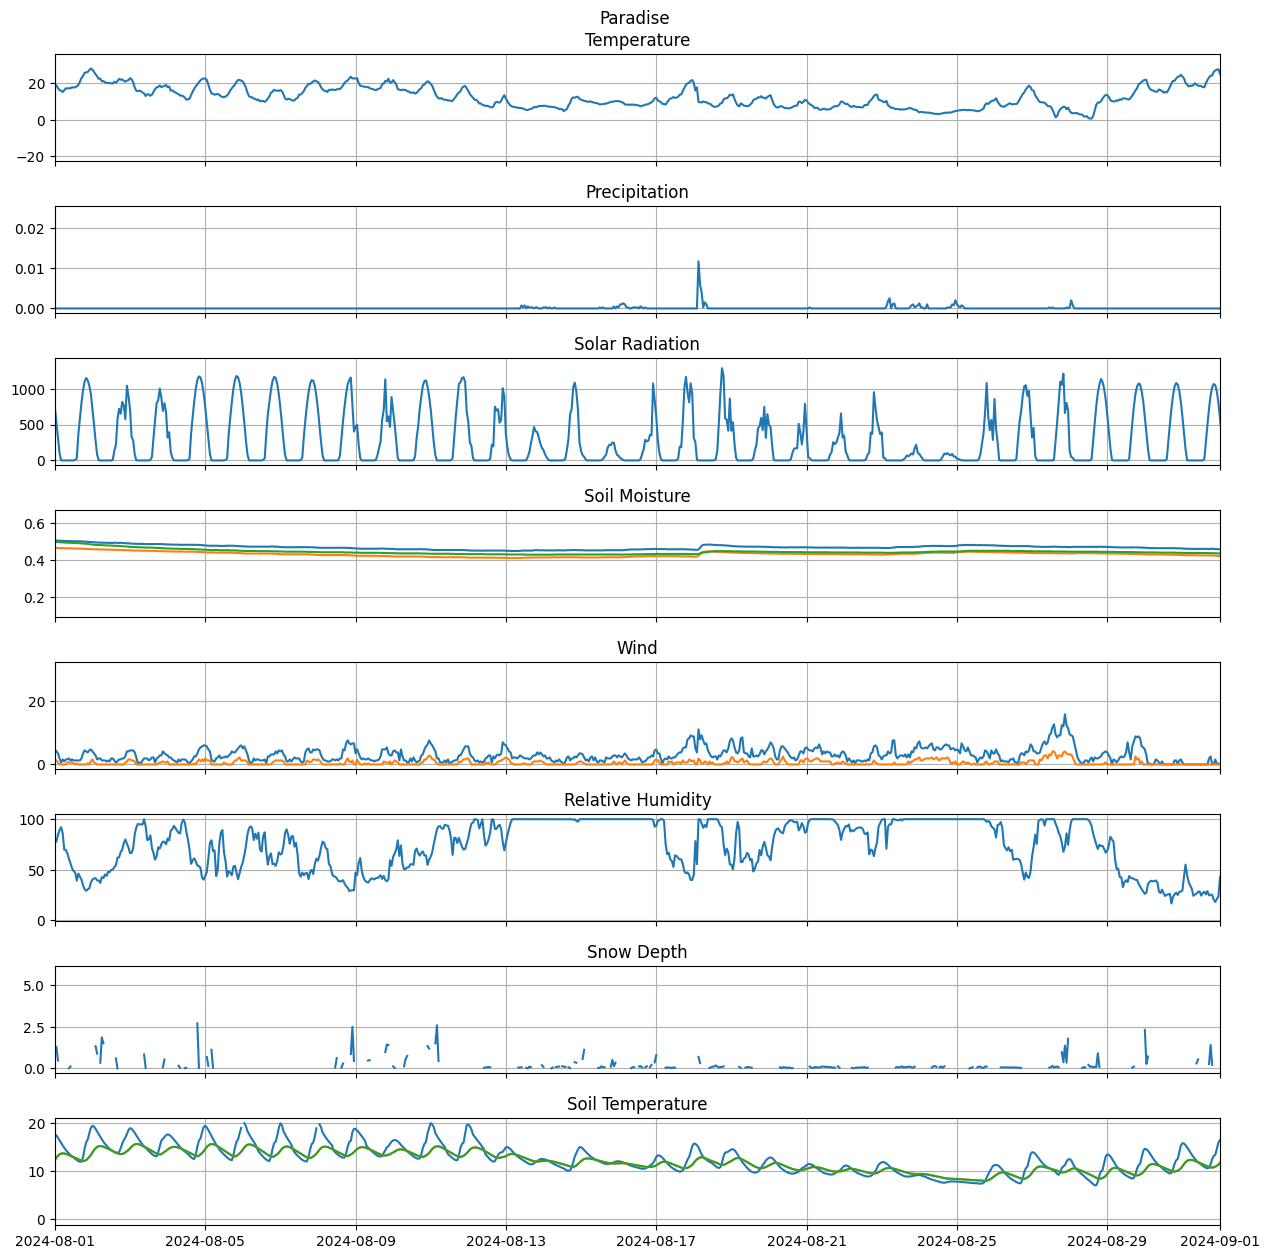

In [15]:
# Set key for Paradise, read the CSV file, and replace index with 'time UTC' and convert to timestamp
key = 'Paradise'
df_NWAC_Paradise = pd.read_csv(f'./data/weather/NWAC/{key}/SI_{key}.csv', index_col='time UTC', parse_dates=True)
print(df_NWAC_Paradise.columns)

fig, ax = plt.subplots(8,1, sharex=True, figsize=(6.4*2, 4.8/3*8))
ax[0].plot(df_NWAC_Paradise[f'{key} Temperature (deg C)'])
ax[1].plot(df_NWAC_Paradise[f'{key} Precipitation (m)'])
ax[2].plot(df_NWAC_Paradise[f'{key}Wind Solar Radiation (W/m2)'])
ax[3].plot(df_NWAC_Paradise[f'{key} Soil Moisture A (VWC)'])
ax[3].plot(df_NWAC_Paradise[f'{key} Soil Moisture B (VWC)'])
ax[3].plot(df_NWAC_Paradise[f'{key} Soil Moisture C (VWC)'])
# ax[4].plot(df_NWAC_Paradise[f'{key}Wind Wind Speed Average (m/s)'])
ax[4].plot(df_NWAC_Paradise[f'{key}Wind Wind Speed Maximum (m/s)'])
ax[4].plot(df_NWAC_Paradise[f'{key}Wind Wind Speed Minimum (m/s)'])
ax[5].plot(df_NWAC_Paradise[f'{key} Relative Humidity (%)'])
ax[6].plot(df_NWAC_Paradise[f'{key} Total Snow Depth (m)'])
ax[7].plot(df_NWAC_Paradise[f'{key} Soil Temperature A (deg C)'])
ax[7].plot(df_NWAC_Paradise[f'{key} Soil Temperature B (deg C)'])
ax[7].plot(df_NWAC_Paradise[f'{key} Soil Temperature C (deg C)'])

# plot average wind speed and direction
# Extract wind direction and speed data
wind_direction = df_NWAC_Paradise[f'{key}Wind Wind Direction (deg.)'].resample('1D').median()
wind_speed = df_NWAC_Paradise[f'{key}Wind Wind Speed Average (m/s)'].resample('1D').median()

# Define arrow lengths based on wind speed
arrow_lengths = wind_speed * 25  # Adjust the scaling factor as needed

# Define arrow components
U = arrow_lengths * np.sin(np.radians(wind_direction))
V = arrow_lengths * np.cos(np.radians(wind_direction))

# Plot wind direction as arrows
# ax[4].quiver(df_NWAC_Paradise.resample('1D').median().index, 0, U, V, units='xy', scale=1)

ax[0].grid(); ax[0].set_title('Temperature')
ax[1].grid(); ax[1].set_title('Precipitation')
ax[2].grid(); ax[2].set_title('Solar Radiation')
ax[3].grid(); ax[3].set_title('Soil Moisture')
ax[4].grid(); ax[4].set_title('Wind')
ax[5].grid(); ax[5].set_title('Relative Humidity')
ax[6].grid(); ax[6].set_title('Snow Depth')
ax[7].grid(); ax[7].set_title('Soil Temperature')

fig.suptitle(f'{key}')
fig.set_tight_layout(True)

ax[7].set_xlim(datetime.datetime(2024,8,1),datetime.datetime(2024,9,1))
# ax[7].set_ylim(0,3)

Index(['CampMuir Net Solar (mJ/m2)', 'CampMuir Relative Humidity (%)',
       'CampMuir Solar Radiation (W/m2)', 'CampMuir Wind Direction (deg.)',
       'CampMuir Temperature (deg C)', 'CampMuir Wind Speed Average (m/s)',
       'CampMuir Wind Speed Maximum (m/s)',
       'CampMuir Wind Speed Minimum (m/s)'],
      dtype='object')


(19570.0, 19997.0)

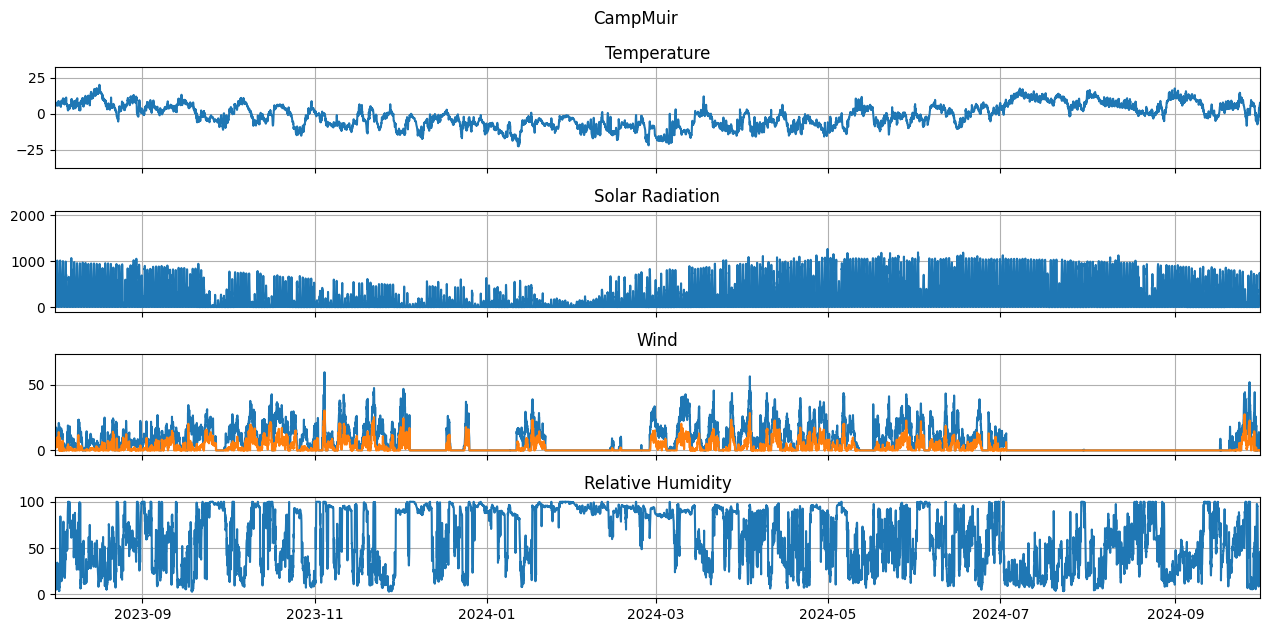

In [21]:
# Set key for CampMuir, read the CSV file, and replace index with 'time UTC' and convert to timestamp
key = 'CampMuir'
df_NWAC_CampMuir = pd.read_csv(f'./data/weather/NWAC/{key}/SI_{key}.csv', index_col='time UTC', parse_dates=True)
print(df_NWAC_CampMuir.columns)

fig, ax = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8/3*4))
ax[0].plot(df_NWAC_CampMuir[f'{key} Temperature (deg C)'])
ax[1].plot(df_NWAC_CampMuir[f'{key} Solar Radiation (W/m2)'])
# ax[1].plot(df_NWAC_CampMuir[f'{key} Net Solar (mJ/m2)'])
# ax[2].plot(df_NWAC_CampMuir[f'{key} Wind Speed Average (m/s)'])
ax[2].plot(df_NWAC_CampMuir[f'{key} Wind Speed Maximum (m/s)'])
ax[2].plot(df_NWAC_CampMuir[f'{key} Wind Speed Minimum (m/s)'])
ax[3].plot(df_NWAC_CampMuir[f'{key} Relative Humidity (%)'])

# plot average wind speed and direction
# Extract wind direction and speed data
wind_direction = df_NWAC_CampMuir[f'{key} Wind Direction (deg.)'].resample('1D').median()
wind_speed = df_NWAC_CampMuir[f'{key} Wind Speed Average (m/s)'].resample('1D').median()

# Define arrow lengths based on wind speed
arrow_lengths = wind_speed * 25  # Adjust the scaling factor as needed

# Define arrow components
U = arrow_lengths * np.sin(np.radians(wind_direction))
V = arrow_lengths * np.cos(np.radians(wind_direction))

# Plot wind direction as arrows
# ax[2].quiver(df_NWAC_CampMuir.resample('1D').median().index, 0, U, V, units='xy', scale=1)

ax[0].grid(); ax[0].set_title('Temperature')
ax[1].grid(); ax[1].set_title('Solar Radiation')
ax[2].grid(); ax[2].set_title('Wind')
ax[3].grid(); ax[3].set_title('Relative Humidity')

fig.suptitle(f'{key}')
fig.set_tight_layout(True)

ax[3].set_xlim(datetime.datetime(2023,8,1),datetime.datetime(2024,10,1))

Index(['SunriseBase Relative Humidity (%)',
       'SunriseBase Soil Moisture A (VWC)',
       'SunriseBase Soil Moisture B (VWC)',
       'SunriseBase Soil Temperature A (deg C)',
       'SunriseBase Soil Temperature B (deg C)',
       'SunriseUpper Relative Humidity (%)',
       'SunriseUpper Solar Radiation (W/m2)',
       'SunriseUpper Wind Direction (deg.)',
       'SunriseBase Total Snow Depth (m)', 'SunriseBase Temperature (deg C)',
       'SunriseUpper Temperature (deg C)',
       'SunriseUpper Wind Speed Average (m/s)',
       'SunriseUpper Wind Speed Maximum (m/s)',
       'SunriseUpper Wind Speed Minimum (m/s)'],
      dtype='object')


(19936.0, 19967.0)

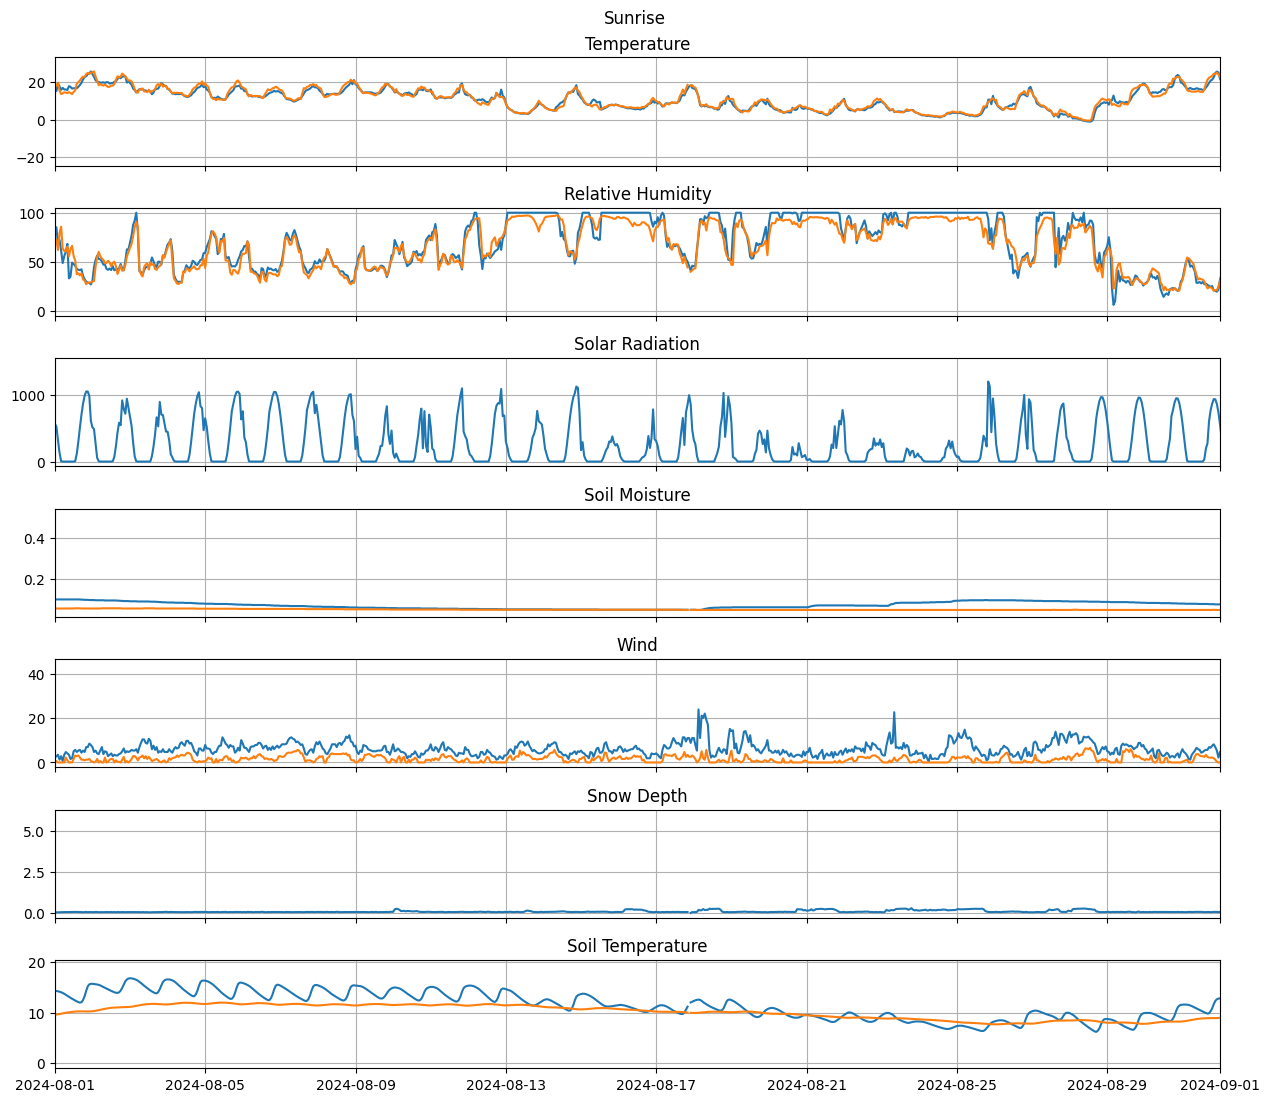

In [28]:
# Set key for Sunrise, read the CSV file, and replace index with 'time UTC' and convert to timestamp
key = 'Sunrise'
df_NWAC_Sunrise = pd.read_csv(f'./data/weather/NWAC/{key}/SI_{key}.csv', index_col='time UTC', parse_dates=True)
print(df_NWAC_Sunrise.columns)

fig, ax = plt.subplots(7,1, sharex=True, figsize=(6.4*2, 4.8/3*7))
ax[0].plot(df_NWAC_Sunrise[f'{key}Upper Temperature (deg C)'])
ax[0].plot(df_NWAC_Sunrise[f'{key}Base Temperature (deg C)'])
ax[1].plot(df_NWAC_Sunrise[f'{key}Upper Relative Humidity (%)'])
ax[1].plot(df_NWAC_Sunrise[f'{key}Base Relative Humidity (%)'])
ax[2].plot(df_NWAC_Sunrise[f'{key}Upper Solar Radiation (W/m2)'])
ax[3].plot(df_NWAC_Sunrise[f'{key}Base Soil Moisture A (VWC)'])
ax[3].plot(df_NWAC_Sunrise[f'{key}Base Soil Moisture B (VWC)'])
# ax[4].plot(df_NWAC_Sunrise[f'{key}Wind Wind Speed Average (m/s)'])
ax[4].plot(df_NWAC_Sunrise[f'{key}Upper Wind Speed Maximum (m/s)'])
ax[4].plot(df_NWAC_Sunrise[f'{key}Upper Wind Speed Minimum (m/s)'])
ax[5].plot(df_NWAC_Sunrise[f'{key}Base Total Snow Depth (m)'])
ax[6].plot(df_NWAC_Sunrise[f'{key}Base Soil Temperature A (deg C)'])
ax[6].plot(df_NWAC_Sunrise[f'{key}Base Soil Temperature B (deg C)'])

# plot average wind speed and direction --------------------------------------------------------------
# Extract wind direction and speed data
wind_direction = df_NWAC_Sunrise[f'{key}Upper Wind Direction (deg.)'].resample('1D').median()
wind_speed = df_NWAC_Sunrise[f'{key}Upper Wind Speed Average (m/s)'].resample('1D').median()

# Define arrow lengths based on wind speed
arrow_lengths = wind_speed * 25  # Adjust the scaling factor as needed

# Define arrow components
U = arrow_lengths * np.sin(np.radians(wind_direction))
V = arrow_lengths * np.cos(np.radians(wind_direction))

# Plot wind direction as arrows
# ax[4].quiver(df_NWAC_Sunrise.resample('1D').median().index, 0, U, V, units='xy', scale=1)

ax[0].grid(); ax[0].set_title('Temperature')
ax[1].grid(); ax[1].set_title('Relative Humidity')
ax[2].grid(); ax[2].set_title('Solar Radiation')
ax[3].grid(); ax[3].set_title('Soil Moisture')
ax[4].grid(); ax[4].set_title('Wind')
ax[5].grid(); ax[5].set_title('Snow Depth')
ax[6].grid(); ax[6].set_title('Soil Temperature')

fig.suptitle(f'{key}')
fig.set_tight_layout(True)

ax[6].set_xlim(datetime.datetime(2024,8,1),datetime.datetime(2024,9,1))

#### NWCC

Index(['TOBS.I-1 (degC)', 'STO.I-1:-2 (degC)', 'STO.I-1:-4 (degC)',
       'STO.I-1:-8 (degC)', 'STO.I-1:-20 (degC)', 'RDC.I-1:-2 (unit)',
       'RDC.I-1:-4 (unit)', 'RDC.I-1:-8 (unit)', 'RDC.I-1:-20 (unit)',
       'WTEQ.I-1 (m)', 'PREC.I-1 (m)', 'SNWD.I-1 (m)', 'SMS.I-1:-2 (%) (silt)',
       'SMS.I-1:-4 (%) (silt)', 'SMS.I-1:-8 (%) (silt)',
       'SMS.I-1:-20 (%) (silt)'],
      dtype='object')


(19936.0, 19967.0)

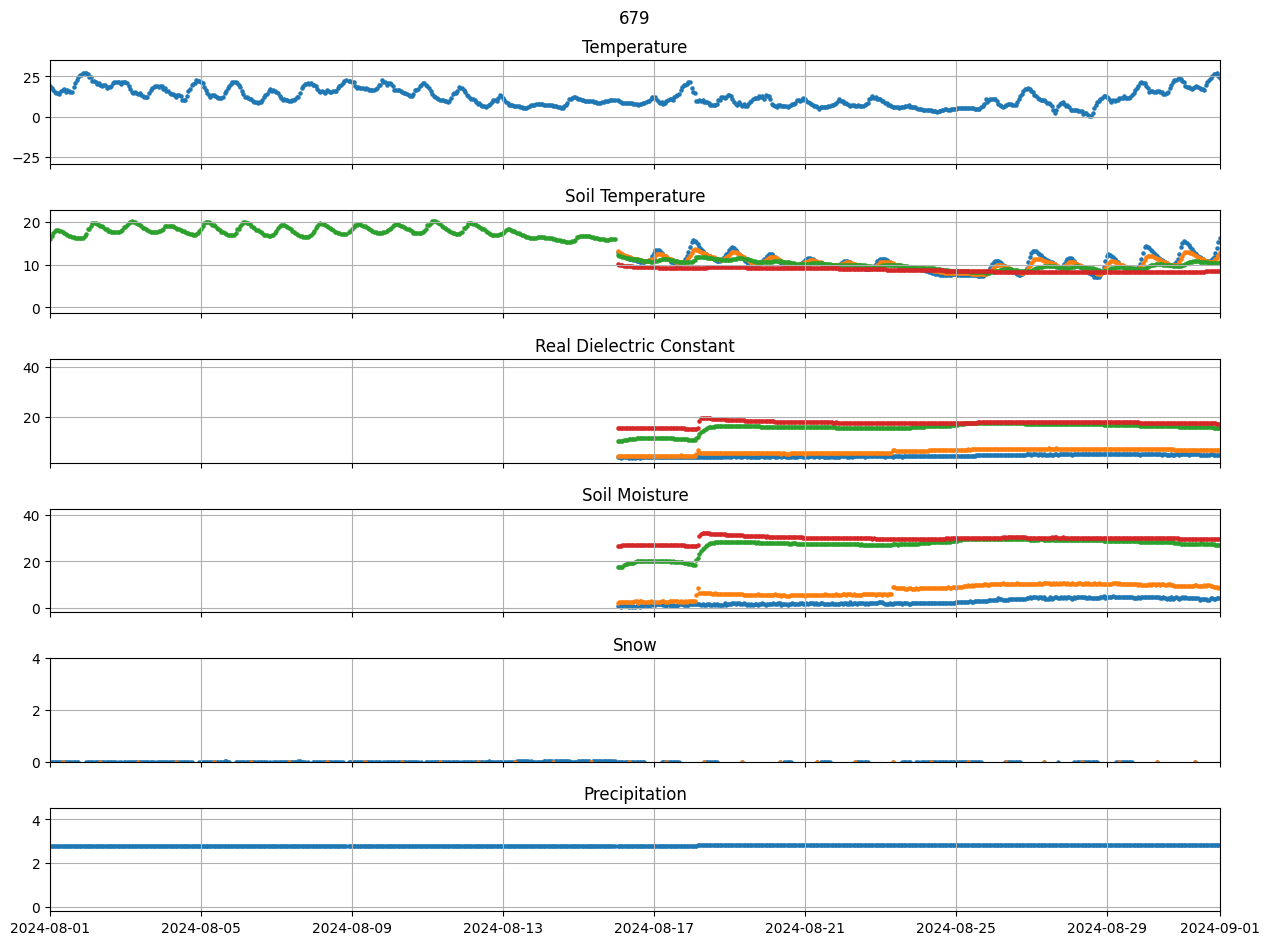

In [41]:
# set key, key is the station location
key = '679'
# read test df, replace index with 'time UTC' and convert to timestamp
df_NWCC_679 = pd.read_csv('./data/weather/NWCC/{}/SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
print(df_NWCC_679.columns)

fig, ax = plt.subplots(6,1, sharex=True, figsize=(6.4*2, 4.8/3*6))
ax[0].scatter(df_NWCC_679.index, df_NWCC_679['TOBS.I-1 (degC)'], s=5)
ax[1].scatter(df_NWCC_679.index, df_NWCC_679['STO.I-1:-2 (degC)'], s=5)
ax[1].scatter(df_NWCC_679.index, df_NWCC_679['STO.I-1:-4 (degC)'], s=5)
ax[1].scatter(df_NWCC_679.index, df_NWCC_679['STO.I-1:-8 (degC)'], s=5)
ax[1].scatter(df_NWCC_679.index, df_NWCC_679['STO.I-1:-20 (degC)'], s=5)
ax[2].scatter(df_NWCC_679.index, df_NWCC_679['RDC.I-1:-2 (unit)'], s=5)
ax[2].scatter(df_NWCC_679.index, df_NWCC_679['RDC.I-1:-4 (unit)'], s=5)
ax[2].scatter(df_NWCC_679.index, df_NWCC_679['RDC.I-1:-8 (unit)'], s=5)
ax[2].scatter(df_NWCC_679.index, df_NWCC_679['RDC.I-1:-20 (unit)'], s=5)
ax[3].scatter(df_NWCC_679.index, df_NWCC_679['SMS.I-1:-2 (%) (silt)'], s=5)
ax[3].scatter(df_NWCC_679.index, df_NWCC_679['SMS.I-1:-4 (%) (silt)'], s=5)
ax[3].scatter(df_NWCC_679.index, df_NWCC_679['SMS.I-1:-8 (%) (silt)'], s=5)
ax[3].scatter(df_NWCC_679.index, df_NWCC_679['SMS.I-1:-20 (%) (silt)'], s=5)
ax[4].scatter(df_NWCC_679.index, df_NWCC_679['WTEQ.I-1 (m)'], s=5)
ax[4].scatter(df_NWCC_679.index, df_NWCC_679['SNWD.I-1 (m)'], s=5)
ax[5].scatter(df_NWCC_679.index, df_NWCC_679['PREC.I-1 (m)'], s=5)
# ax[5].scatter(df_NWCC_679.index, df_NWCC_679['PREC.I-1 (m)'].diff().where(lambda x: x >= 0)*1000, s=5)


ax[0].grid(); ax[0].set_title('Temperature')
ax[1].grid(); ax[1].set_title('Soil Temperature')
ax[2].grid(); ax[2].set_title('Real Dielectric Constant')
ax[3].grid(); ax[3].set_title('Soil Moisture')
ax[4].grid(); ax[4].set_title('Snow')
ax[5].grid(); ax[5].set_title('Precipitation')

fig.suptitle(f'{key}')
fig.set_tight_layout(True)

ax[4].set_ylim(0,4)

ax[5].set_xlim(datetime.datetime(2024,8,1),datetime.datetime(2024,9,1))

Index(['TOBS.I-1 (degC)', 'STO.I-1:-2 (degC)', 'STO.I-1:-4 (degC)',
       'STO.I-1:-8 (degC)', 'STO.I-1:-20 (degC)', 'STO.I-1:-32 (degC)',
       'RDC.I-1:-2 (unit)', 'RDC.I-1:-4 (unit)', 'RDC.I-1:-8 (unit)',
       'RDC.I-1:-20 (unit)', 'RDC.I-1:-32 (unit)', 'TAVG.H-2 (degC)',
       'WDIRV.H-1 (degr)', 'WTEQ.I-1 (m)', 'PREC.I-1 (m)', 'SNWD.I-1 (m)',
       'SMS.I-1:-2 (%) (silt)', 'SMS.I-1:-4 (%) (silt)',
       'SMS.I-1:-8 (%) (silt)', 'SMS.I-1:-20 (%) (silt)',
       'SMS.I-1:-32 (%) (silt)', 'WSPDX.H-1 (m/s)', 'WSPDV.H-1 (m/s)'],
      dtype='object')


(19936.0, 19967.0)

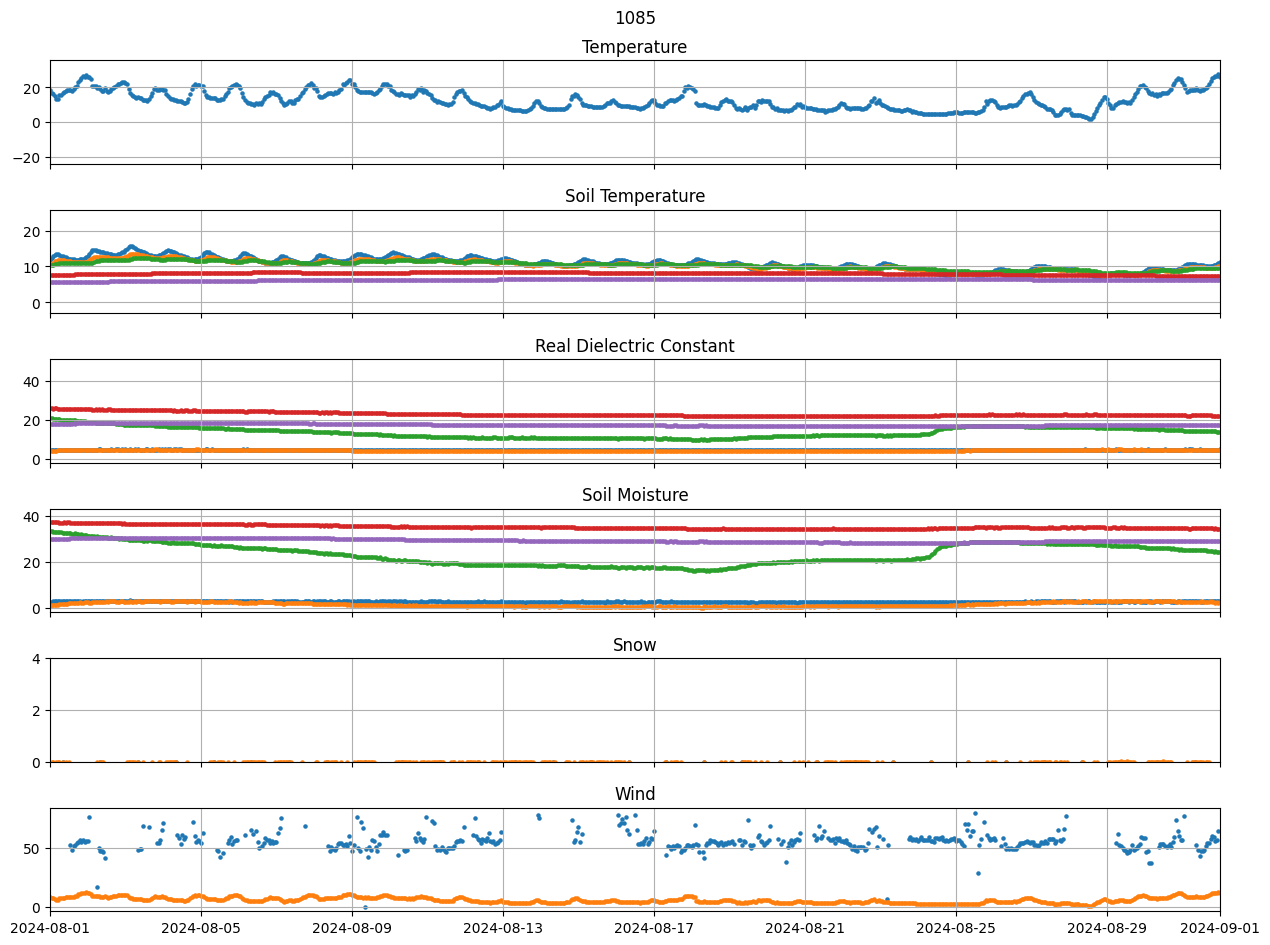

In [54]:
# set key, key is the station location
key = '1085'
# read test df, replace index with 'time UTC' and convert to timestamp
df_NWCC_1085 = pd.read_csv('./data/weather/NWCC/{}/SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
print(df_NWCC_1085.columns)

fig, ax = plt.subplots(6,1, sharex=True, figsize=(6.4*2, 4.8/3*6))
ax[0].scatter(df_NWCC_1085.index, df_NWCC_1085['TOBS.I-1 (degC)'], s=5)
ax[0].scatter(df_NWCC_1085.index, df_NWCC_1085['TAVG.H-2 (degC)'], s=5)
ax[1].scatter(df_NWCC_1085.index, df_NWCC_1085['STO.I-1:-2 (degC)'], s=5)
ax[1].scatter(df_NWCC_1085.index, df_NWCC_1085['STO.I-1:-4 (degC)'], s=5)
ax[1].scatter(df_NWCC_1085.index, df_NWCC_1085['STO.I-1:-8 (degC)'], s=5)
ax[1].scatter(df_NWCC_1085.index, df_NWCC_1085['STO.I-1:-20 (degC)'], s=5)
ax[1].scatter(df_NWCC_1085.index, df_NWCC_1085['STO.I-1:-32 (degC)'], s=5)
ax[2].scatter(df_NWCC_1085.index, df_NWCC_1085['RDC.I-1:-2 (unit)'], s=5)
ax[2].scatter(df_NWCC_1085.index, df_NWCC_1085['RDC.I-1:-4 (unit)'], s=5)
ax[2].scatter(df_NWCC_1085.index, df_NWCC_1085['RDC.I-1:-8 (unit)'], s=5)
ax[2].scatter(df_NWCC_1085.index, df_NWCC_1085['RDC.I-1:-20 (unit)'], s=5)
ax[2].scatter(df_NWCC_1085.index, df_NWCC_1085['RDC.I-1:-32 (unit)'], s=5)
ax[3].scatter(df_NWCC_1085.index, df_NWCC_1085['SMS.I-1:-2 (%) (silt)'], s=5)
ax[3].scatter(df_NWCC_1085.index, df_NWCC_1085['SMS.I-1:-4 (%) (silt)'], s=5)
ax[3].scatter(df_NWCC_1085.index, df_NWCC_1085['SMS.I-1:-8 (%) (silt)'], s=5)
ax[3].scatter(df_NWCC_1085.index, df_NWCC_1085['SMS.I-1:-20 (%) (silt)'], s=5)
ax[3].scatter(df_NWCC_1085.index, df_NWCC_1085['SMS.I-1:-32 (%) (silt)'], s=5)
ax[4].scatter(df_NWCC_1085.index, df_NWCC_1085['WTEQ.I-1 (m)'], s=5)
ax[4].scatter(df_NWCC_1085.index, df_NWCC_1085['SNWD.I-1 (m)'], s=5)
ax[5].scatter(df_NWCC_1085.index, df_NWCC_1085['WSPDX.H-1 (m/s)'], s=5)
ax[5].scatter(df_NWCC_1085.index, df_NWCC_1085['WSPDV.H-1 (m/s)'], s=5)
# ax[5].scatter(df_NWCC_1085.index, df_NWCC_1085['WDIRV.H-1 (degr)'], s=5)
# ax[6].scatter(df_NWCC_1085.index, df_NWCC_1085['PREC.I-1 (m)'], s=5)

# plot average wind speed and direction
# Extract wind direction and speed data
wind_direction = df_NWCC_1085['WDIRV.H-1 (degr)'].resample('1D').median()
wind_speed = df_NWCC_1085['WSPDV.H-1 (m/s)'].resample('1D').median()

# Define arrow lengths based on wind speed
arrow_lengths = wind_speed * 50  # Adjust the scaling factor as needed

# Define arrow components
U = arrow_lengths * np.sin(np.radians(wind_direction))
V = arrow_lengths * np.cos(np.radians(wind_direction))

# Plot wind direction as arrows
# ax[5].quiver(df_NWCC_1085.resample('1D').median().index, 0, U, V, units='xy', scale=1)

ax[0].grid(); ax[0].set_title('Temperature')
ax[1].grid(); ax[1].set_title('Soil Temperature')
ax[2].grid(); ax[2].set_title('Real Dielectric Constant')
ax[3].grid(); ax[3].set_title('Soil Moisture')
ax[4].grid(); ax[4].set_title('Snow')
ax[5].grid(); ax[5].set_title('Wind')
# ax[6].grid(); ax[6].set_title('Precipitation')

fig.suptitle(f'{key}')
fig.set_tight_layout(True)

ax[4].set_ylim(0,4)

ax[5].set_xlim(datetime.datetime(2024,8,1),datetime.datetime(2024,9,1))

#### River

Index(['Discharge, (m/s)', 'Gage height, (m)'], dtype='object')
Index(['Discharge, (m/s)', 'Gage height, (m)'], dtype='object')


(19936.0, 19967.0)

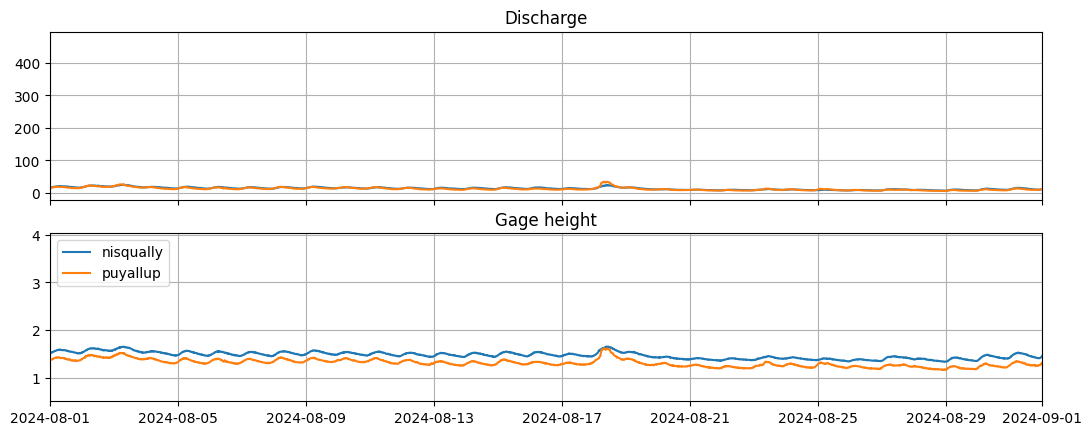

In [69]:
# set key, key is the station location
key = 'nisqually'
# read test df, replace index with 'time UTC' and convert to timestamp
df_river_nisqually = pd.read_csv('./data/weather/river/{}/SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
print(df_river_nisqually.columns)

# set key, key is the station location
key = 'puyallup'
# read test df, replace index with 'time UTC' and convert to timestamp
df_river_puyallup = pd.read_csv('./data/weather/river/{}/SI_{}.csv'.format(key,key),
                      index_col='time UTC', parse_dates=True)
print(df_river_puyallup.columns)

fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(df_river_nisqually['Discharge, (m/s)'], label='nisqually')
ax[0].plot(df_river_puyallup['Discharge, (m/s)'], label='puyallup')
ax[1].plot(df_river_nisqually['Gage height, (m)'], label='nisqually')
ax[1].plot(df_river_puyallup['Gage height, (m)'], label='puyallup')
plt.legend(loc='upper left')
ax[0].grid(); ax[0].set_title('Discharge')
ax[1].grid(); ax[1].set_title('Gage height')
ax[1].set_xlim(datetime.datetime(2024,8,1),datetime.datetime(2024,9,1))
# plt.show()

### Plot sepcific parameters

In [71]:
def read_csv_data(base_path, keys, file_prefix):
    """
    Reads CSV files for given keys and returns a dictionary of DataFrames.
    
    Parameters:
    - base_path: str, base path to the CSV files
    - keys: list of str, keys representing the station locations
    - file_prefix: str, prefix for the CSV files
    
    Returns:
    - dict: dictionary with keys as station locations and values as DataFrames
    """
    dataframes = {}
    for key in keys:
        file_path = f'{base_path}/{key}/{file_prefix}_{key}.csv'
        df = pd.read_csv(file_path, index_col='time UTC', parse_dates=True)
        dataframes[key] = df
        # print(f'{key} columns:', df.columns)
    return dataframes

# Keys for NWAC data
nwac_keys = ['Paradise', 'Sunrise'] #['Paradise', 'CampMuir', 'Sunrise']
dic_NWAC = read_csv_data('./data/weather/NWAC', nwac_keys, 'SI')

# Keys for NWCC data
nwcc_keys = ['679', '1085']#['679', '1085']
dic_NWCC = read_csv_data('./data/weather/NWCC', nwcc_keys, 'SI')

# Keys for river data
river_keys = ['nisqually', 'puyallup']
dic_river = read_csv_data('./data/weather/river', river_keys, 'SI')

In [72]:
dic_NWAC['Paradise']

,ParadiseWind Solar Radiation (W/m2),ParadiseWind Wind Direction (deg.),Paradise Relative Humidity (%),Paradise Soil Moisture A (VWC),Paradise Soil Moisture B (VWC),Paradise Soil Moisture C (VWC),Paradise Soil Temperature A (deg C),Paradise Soil Temperature B (deg C),Paradise Soil Temperature C (deg C),ParadiseWind Wind Speed Average (m/s),ParadiseWind Wind Speed Maximum (m/s),ParadiseWind Wind Speed Minimum (m/s),Paradise Precipitation (m),Paradise Total Snow Depth (m),Paradise Temperature (deg C)
time UTC,,,,,,,,,,,,,,,
2016-01-01 08:00:00,0.0,84.300,37.32,NaN,NaN,NaN,NaN,NaN,NaN,4.984496,11.426342,2.221789,0.000000,2.93624,-1.616667
2016-01-01 09:00:00,0.0,84.600,29.92,NaN,NaN,NaN,NaN,NaN,NaN,3.285744,6.982765,1.269594,0.000000,2.92354,-0.355556
2016-01-01 10:00:00,0.0,69.160,31.38,NaN,NaN,NaN,NaN,NaN,NaN,3.473501,7.617562,1.586992,0.000000,2.93878,-0.688889
2016-01-01 11:00:00,0.0,61.290,28.78,NaN,NaN,NaN,NaN,NaN,NaN,3.509264,7.934960,1.586992,0.000000,2.94640,-0.488889
2016-01-01 12:00:00,0.0,55.730,34.64,NaN,NaN,NaN,NaN,NaN,NaN,3.451149,6.030570,1.269594,0.000000,2.93624,-0.361111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 03:00:00,0.0,32.510,94.60,0.523,0.489,0.526,0.502,0.591,0.591,0.384007,2.209272,0.000000,0.000000,3.07848,-5.950000
2025-01-01 04:00:00,0.0,0.906,94.80,0.523,0.488,0.525,0.502,0.593,0.593,0.776956,2.840492,0.000000,0.000254,3.08102,-5.711111
2025-01-01 05:00:00,0.0,15.300,94.70,0.522,0.488,0.525,0.501,0.592,0.592,0.525272,1.893661,0.000000,0.000254,3.08356,-6.000000


In [94]:
def extract_columns_to_df(dic_list, list_cols, start_time, end_time):
    """
    Extracts specified columns from dictionaries within a given time range and combines them into a new DataFrame.
    
    Parameters:
    - dic_list: list of dict, list of dictionaries to search through
    - list_cols: list of str, list of column patterns to search for
    - start_time: str or datetime, start time for the data extraction
    - end_time: str or datetime, end time for the data extraction
    
    Returns:
    - DataFrame: combined DataFrame with the specified columns within the given time range
    """
    combined_df = pd.DataFrame()
    for dic in dic_list:
        for key, df in dic.items():
            for col_pattern in list_cols:
                matching_cols = df.filter(like=col_pattern).columns
                for col in matching_cols:
                    new_col_name = f'{key}_{col}'
                    filtered_df = df.loc[start_time:end_time, col].rename(new_col_name)
                    combined_df = pd.concat([combined_df, filtered_df], axis=1)
    return combined_df

# List of column patterns to search for
list_cols = ['Soil Moisture', 'SMS'] #'Precipitation', 

# Define start and end time
start_time = '2024-05-01'
end_time = '2024-09-01'

# Extract columns and combine into a new DataFrame
all_dics = [dic_NWAC, dic_NWCC, dic_river]
combined_df = extract_columns_to_df(all_dics, list_cols, start_time, end_time)

# Print the combined DataFrame
combined_df

,Paradise_Paradise Soil Moisture A (VWC),Paradise_Paradise Soil Moisture B (VWC),Paradise_Paradise Soil Moisture C (VWC),Sunrise_SunriseBase Soil Moisture A (VWC),Sunrise_SunriseBase Soil Moisture B (VWC),679_SMS.I-1:-2 (%) (silt),679_SMS.I-1:-4 (%) (silt),679_SMS.I-1:-8 (%) (silt),679_SMS.I-1:-20 (%) (silt),1085_SMS.I-1:-2 (%) (silt),1085_SMS.I-1:-4 (%) (silt),1085_SMS.I-1:-8 (%) (silt),1085_SMS.I-1:-20 (%) (silt),1085_SMS.I-1:-32 (%) (silt)
2024-05-01 00:00:00,0.526,0.499,0.612,0.195,0.164,25.5,25.3,34.7,34.5,30.0,20.5,37.4,40.0,36.7
2024-05-01 01:00:00,0.525,0.499,0.612,0.195,0.164,25.5,25.3,34.7,34.5,30.0,20.4,37.6,40.0,36.7
2024-05-01 02:00:00,0.525,0.499,0.612,0.195,0.164,25.5,25.3,34.7,34.6,29.9,20.3,37.5,40.0,36.7
2024-05-01 03:00:00,0.525,0.499,0.612,0.195,0.164,25.5,25.3,34.7,34.6,29.9,20.3,37.6,39.9,36.7
2024-05-01 04:00:00,0.525,0.499,0.612,0.195,0.164,25.4,25.3,34.7,34.5,29.9,20.3,37.4,40.0,36.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01 20:00:00,0.454,0.418,0.434,0.073,0.051,3.7,8.6,26.5,29.3,2.6,2.2,23.2,34.4,29.0
2024-09-01 21:00:00,0.454,0.418,0.433,0.073,0.050,3.5,8.3,26.4,29.3,2.9,2.1,22.9,34.4,29.0
2024-09-01 22:00:00,0.454,0.418,0.433,0.073,0.050,3.6,8.3,26.3,29.3,2.7,2.1,22.9,34.3,29.0
2024-09-01 23:00:00,0.453,0.417,0.433,0.072,0.050,3.8,8.1,26.2,29.2,2.7,1.8,22.7,34.3,28.9


Paradise_Paradise Soil Moisture A (VWC) Paradise_Paradise Soil Moisture A (VWC)
Paradise_Paradise Soil Moisture B (VWC) Paradise_Paradise Soil Moisture B (VWC)
Paradise_Paradise Soil Moisture C (VWC) Paradise_Paradise Soil Moisture C (VWC)
Sunrise_SunriseBase Soil Moisture A (VWC) Sunrise_SunriseBase Soil Moisture A (VWC)
Sunrise_SunriseBase Soil Moisture B (VWC) Sunrise_SunriseBase Soil Moisture B (VWC)
679_SMS.I-1:-2 (%) (silt) 679_SMS.I-1:-2 (%) (silt)
679_SMS.I-1:-4 (%) (silt) 679_SMS.I-1:-4 (%) (silt)
679_SMS.I-1:-8 (%) (silt) 679_SMS.I-1:-8 (%) (silt)
679_SMS.I-1:-20 (%) (silt) 679_SMS.I-1:-20 (%) (silt)
1085_SMS.I-1:-2 (%) (silt) 1085_SMS.I-1:-2 (%) (silt)
1085_SMS.I-1:-4 (%) (silt) 1085_SMS.I-1:-4 (%) (silt)
1085_SMS.I-1:-8 (%) (silt) 1085_SMS.I-1:-8 (%) (silt)
1085_SMS.I-1:-20 (%) (silt) 1085_SMS.I-1:-20 (%) (silt)
1085_SMS.I-1:-32 (%) (silt) 1085_SMS.I-1:-32 (%) (silt)


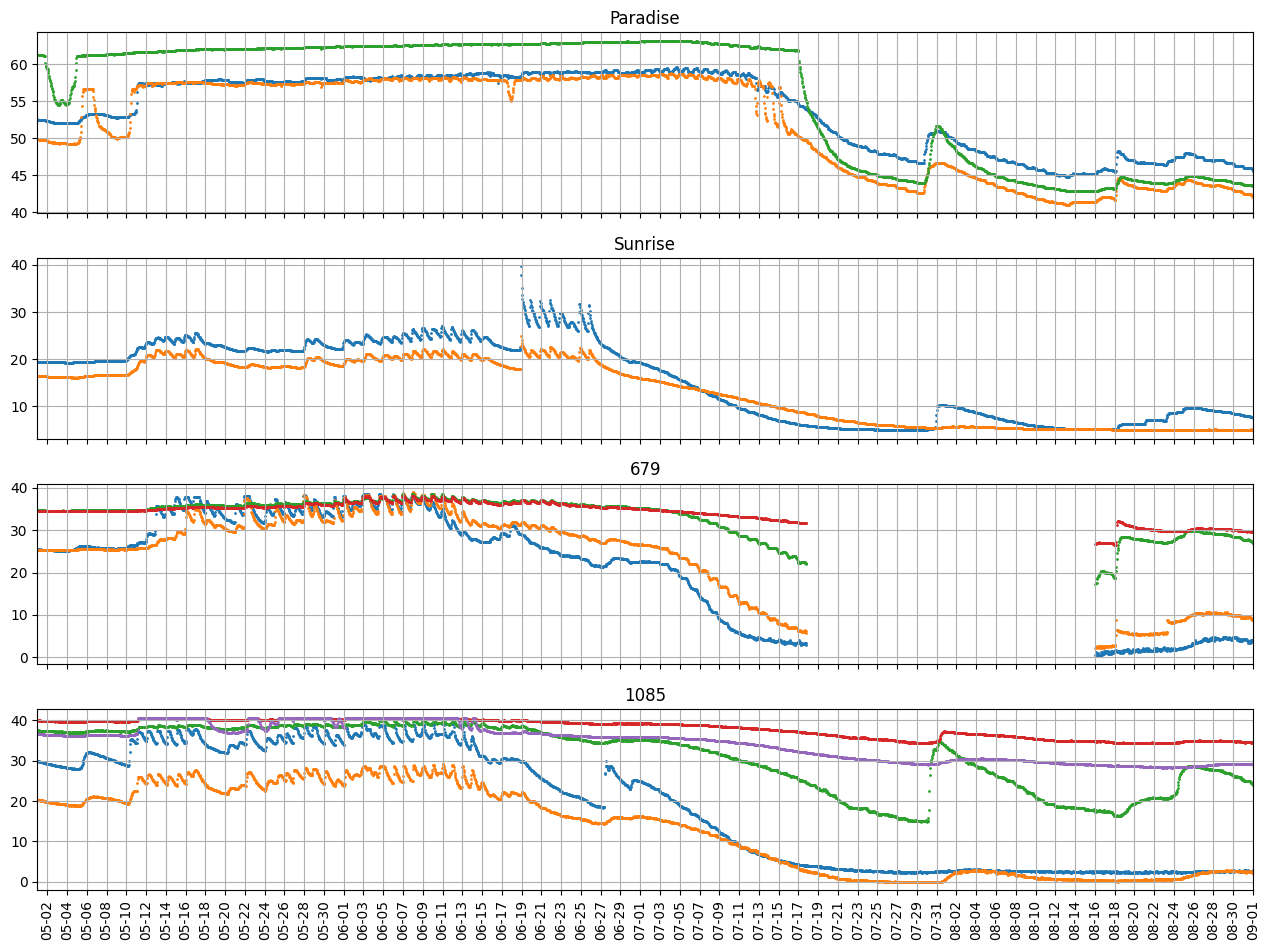

In [95]:
import re

def similar(a, b):
    """
    Returns the similarity ratio between two strings.
    """
    return SequenceMatcher(None, a, b).ratio()

columns = combined_df.columns
subplots = []

for col in columns:
    # Check if all values in the column are between 0 and 1 and multiply by 100 (%)
    if combined_df[col].dropna().between(0, 1).all():
        combined_df[col] *= 100

    added = False
    for subplot in subplots:
        if any(similar(col, existing_col) > 0.9 for existing_col in subplot):
            subplot.append(col)
            added = True
            break
    if not added:
        subplots.append([col])

# Define regex patterns for replacement with exact space condition
label_mapping = {" A ": " 20 cm ", " B ": " 40 cm ", " C ": " 60 cm "}

n = len(subplots)
fig, axes = plt.subplots(n, 1, sharex=True, figsize=(6.4 * 2, 4.8 * 0.5 * n))

if n == 1:
    axes = [axes]

for ax, subplot in zip(axes, subplots):
    for col in subplot:
        label = col
        replaced = False

        # Replace labels with mapped values if patterns match
        for key, value in label_mapping.items():
            if f"{key.strip()}" in col:
                label = re.sub(rf"\b{key.strip()}\b", value.strip(), col)
                replaced = True
                break
        # Replace "(%) (silt)" with "(VWC)"
        label = re.sub(r"(%) (silt)", "(VWC)", col)
        print(col, label)

        # If no pattern matched, prepend "in " before the first space
        if not replaced:
            label = re.sub(r" ", " in ", col, 1)

        ax.scatter(combined_df.index, combined_df[col], label=label, s=1)

    title_part = subplot[0].split('_')[0]
    ax.set_title(title_part)
    # ax.legend(loc='upper right')
    ax.grid()

# Set the x-axis major formatter to DateFormatter
# axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axes[-1].xaxis.set_major_locator(mdates.DayLocator(interval=2))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Rotate the x-axis labels for better readability
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=90)

# Convert strings to datetime objects
datetime_start_time = datetime.datetime.strptime(start_time, '%Y-%m-%d')
datetime_end_time = datetime.datetime.strptime(end_time, '%Y-%m-%d')

# Set x-axis limits
axes[-1].set_xlim(datetime_start_time, datetime_end_time)

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()


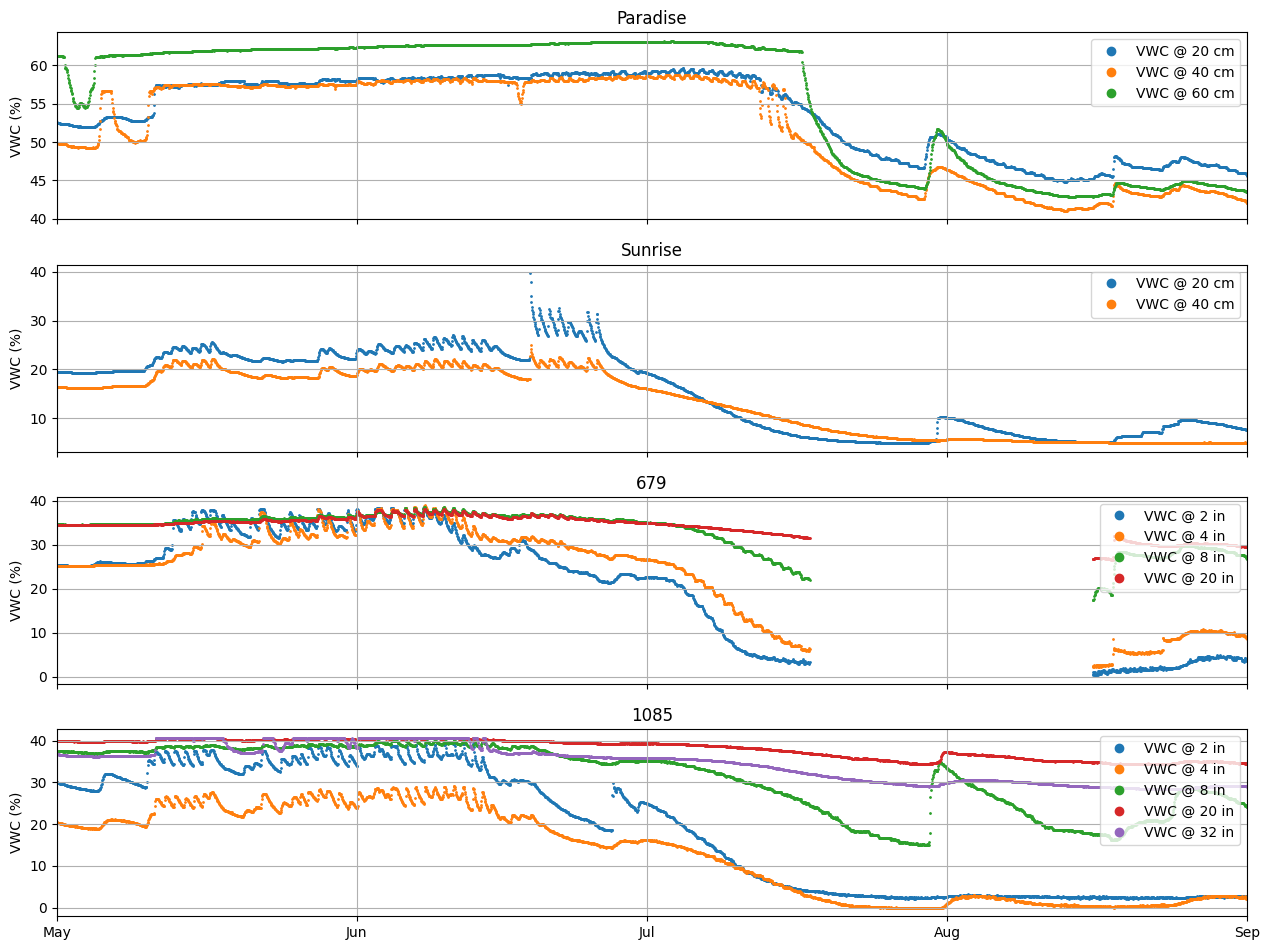

In [96]:
import re
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from difflib import SequenceMatcher

def similar(a, b):
    """Returns the similarity ratio between two strings."""
    return SequenceMatcher(None, a, b).ratio()

# Define label mappings based on column prefixes
label_mappings = {
    "Paradise": ["VWC @ 20 cm", "VWC @ 40 cm", "VWC @ 60 cm"],
    "Sunrise": ["VWC @ 20 cm", "VWC @ 40 cm"],
    "679": ["VWC @ 2 in", "VWC @ 4 in", "VWC @ 8 in", "VWC @ 20 in"],
    "1085": ["VWC @ 2 in", "VWC @ 4 in", "VWC @ 8 in", "VWC @ 20 in", "VWC @ 32 in"],
}

# Group columns into four separate lists
subplots = {key: [] for key in label_mappings}

for col in combined_df.columns:
    for key in label_mappings:
        if col.startswith(key):
            subplots[key].append(col)
            break

# Create subplots (one for each category)
n = len(subplots)
fig, axes = plt.subplots(n, 1, sharex=True, figsize=(6.4 * 2, 4.8 * 0.5 * n))

if n == 1:
    axes = [axes]

for ax, (group, cols) in zip(axes, subplots.items()):
    for idx, col in enumerate(cols):
        label_list = label_mappings[group]
        label = label_list[idx] if idx < len(label_list) else col  # Assign label from predefined list

        ax.scatter(combined_df.index, combined_df[col], label=label, s=1)
        
        # Create a custom legend with larger markers
        import matplotlib.lines as mlines
        handles, labels = ax.get_legend_handles_labels()
        legend_handles = [mlines.Line2D([], [], color=h.get_facecolor()[0], marker='o', linestyle='', markersize=6) for h in handles]

        ax.legend(legend_handles, labels, loc='upper right', scatterpoints=1)

    ax.set_title(group)
    ax.set_ylabel('VWC (%)')
    # ax.legend(loc='upper right')
    ax.grid()

# Format x-axis
axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=0)

# Convert strings to datetime
datetime_start_time = datetime.datetime.strptime(start_time, '%Y-%m-%d')
datetime_end_time = datetime.datetime.strptime(end_time, '%Y-%m-%d')

# Set x-axis limits
axes[-1].set_xlim(datetime_start_time, datetime_end_time)

# Adjust layout
fig.tight_layout()
plt.show()


### Plot all (interactive)

In [5]:
import ipywidgets as widgets
from IPython.display import display

# Put all your dataframes in a dictionary with station names
dfs = {
    "Paradise": df_NWAC_Paradise,
    "CampMuir": df_NWAC_CampMuir,
    "Sunrise": df_NWAC_Sunrise,
    "679": df_NWCC_679,
    "1085": df_NWCC_1085,
    "Nisqually": df_river_nisqually,
    "Puyallup": df_river_puyallup,
}

# Define grouping keywords
groups = {
    "Soil Moisture": ["Soil Moisture", "SMS"],
    "Soil Temperature": ["Soil Temperature", "STO"],
    "Real Dielectric Constant": ["RDC"],
    "Temperature": ["Temperature", "TOBS", "TAVG"],
    "Snow Depth": ["Snow Depth", "SNWD", "WTEQ"],
    "Precipitation": ["Precipitation", "PREC"],
    "Solar Radiation": ["Solar Radiation", "Solar", "Net Solar"],
    "Wind Speed": ["Wind Speed", "WSPDV", "WSPDX"],
    "Wind Direction": ["Wind Direction", "WDIRV"],
    "Discharge": ["Discharge"],
    "Gage height": ["Gage height"],
}

def group_columns(df):
    grouped = {g: [] for g in groups}
    for col in df.columns:
        found = False
        for gname, keywords in groups.items():
            if any(kw in col for kw in keywords):
                grouped[gname].append(col)
                found = True
                break
        if not found:
            grouped.setdefault("Other", []).append(col)
    return {g: cols for g, cols in grouped.items() if cols}

def plot_station(station, start_date=None, end_date=None):
    df = dfs[station]
    if start_date and end_date:
        df = df.loc[start_date:end_date]

    grouped_cols = group_columns(df)
    nplots = len(grouped_cols)

    fig, axes = plt.subplots(nplots, 1, figsize=(10, 3*nplots))
    if nplots == 1:
        axes = [axes]

    for ax, (gname, cols) in zip(axes, grouped_cols.items()):
        # Special ordering for wind speed
        if gname == "Wind Speed":
            order = ["Maximum", "Average", "Minimum"]  # keyword order
            cols = sorted(cols, key=lambda c: next((i for i, o in enumerate(order) if o in c), len(order)))
        for col in cols:
            ax.scatter(df.index, df[col], s=10, label=col)
        ax.set_ylabel(gname)
        ax.legend(fontsize=8, loc="upper left")
        ax.grid(True)
    axes[-1].set_xlabel("Time (UTC)")
    fig.suptitle(f"{station} - All Parameters Grouped", fontsize=14)
    plt.tight_layout()
    plt.show()

# Widgets
station_dropdown = widgets.Dropdown(
    options=list(dfs.keys()),
    value="Paradise",
    description="Station:",
    style={"description_width": "initial"}
)

# Min/max date for all data
global_min_date = datetime.date(2023,8,1) # min(df.index.min() for df in dfs.values()).date()
global_max_date = datetime.date(2024,10,1) # max(df.index.max() for df in dfs.values()).date()

# Custom date pickers with YYYY-MM-DD format
start_picker = widgets.DatePicker(
    description="Start",
    value=global_min_date
)
end_picker = widgets.DatePicker(
    description="End",
    value=global_max_date
)

out = widgets.Output()

def update_plot(change=None):
    with out:
        out.clear_output(wait=True)
        plot_station(
            station_dropdown.value,
            start_date=start_picker.value,
            end_date=end_picker.value
        )

station_dropdown.observe(update_plot, names="value")
start_picker.observe(update_plot, names="value")
end_picker.observe(update_plot, names="value")

display(widgets.HBox([station_dropdown, start_picker, end_picker]))
display(out)

update_plot()


Output()

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Data dictionary: station name -> dataframe
dfs = {
    "Paradise": df_NWAC_Paradise,
    "CampMuir": df_NWAC_CampMuir,
    "Sunrise": df_NWAC_Sunrise,
    "679": df_NWCC_679,
    "1085": df_NWCC_1085,
    "Nisqually": df_river_nisqually,
    "Puyallup": df_river_puyallup,
}

# Group definitions
groups = {
    "Soil Moisture": ["Soil Moisture", "SMS"],
    "Soil Temperature": ["Soil Temperature", "STO"],
    "Real Dielectric Constant": ["RDC"],
    "Temperature": ["Temperature", "TOBS", "TAVG"],
    "Snow Depth": ["Snow Depth", "SNWD", "WTEQ"],
    "Precipitation": ["Precipitation", "PREC", ],
    "Solar Radiation": ["Solar Radiation", "Solar", "Net Solar"],
    "Wind Speed": ["Wind Speed", "WSPDV", "WSPDX"],
    "Wind Direction": ["Wind Direction", "WDIRV"],
    "Discharge": ["Discharge"],
    "Gage height": ["Gage height"],
}

def group_columns(df):
    grouped = {g: [] for g in groups}
    for col in df.columns:
        for gname, keywords in groups.items():
            if any(kw in col for kw in keywords):
                grouped[gname].append(col)
                break
    return {g: cols for g, cols in grouped.items() if cols}

def plot_parameter_group(param_group, start_date=None, end_date=None):
    # Filter stations that have columns for the selected parameter group
    stations_with_data = {}
    for station, df in dfs.items():
        grouped_cols = group_columns(df)
        if param_group in grouped_cols:
            stations_with_data[station] = df

    nstations = len(stations_with_data)
    if nstations == 0:
        print(f"No stations have data for {param_group}")
        return

    fig, axes = plt.subplots(nstations, 1, figsize=(10, 3*nstations))

    # Make axes iterable
    if nstations == 1:
        axes = [axes]

    for ax, (station, df) in zip(axes, stations_with_data.items()):
        if start_date and end_date:
            df = df.loc[start_date:end_date]

        cols = group_columns(df)[param_group]

        # Custom sort for wind speed
        if param_group == "Wind Speed":
            order = ["Maximum", "Average", "Minimum"]
            cols = sorted(cols, key=lambda c: next((i for i, o in enumerate(order) if o in c), len(order)))

        for col in cols:
            ax.scatter(df.index, df[col], s=10, label=col)

        ax.set_ylabel(station)
        ax.legend(fontsize=8, loc="upper left")
        ax.grid(True)

    axes[-1].set_xlabel("Time (UTC)")
    fig.suptitle(f"{param_group} across Stations", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
    plt.show()
    return None

# Widgets
param_dropdown = widgets.Dropdown(
    options=list(groups.keys()),
    value="Temperature",
    description="Parameter:",
    style={"description_width": "initial"}
)

global_min_date = datetime.date(2023,8,1) # min(df.index.min() for df in dfs.values()).date()
global_max_date = datetime.date(2024,10,1) # max(df.index.max() for df in dfs.values()).date()

start_picker = widgets.DatePicker(description="Start", value=global_min_date)
end_picker = widgets.DatePicker(description="End", value=global_max_date)

out = widgets.Output()

def update_plot(change=None):
    with out:
        out.clear_output(wait=True)
        plot_parameter_group(
            param_dropdown.value,
            start_date=start_picker.value,
            end_date=end_picker.value
        )

param_dropdown.observe(update_plot, names="value")
start_picker.observe(update_plot, names="value")
end_picker.observe(update_plot, names="value")

display(widgets.HBox([param_dropdown, start_picker, end_picker]))
display(out)

update_plot()


Output()